In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances
import pickle
import ratingSOM 
from ratingSOM import EvalProcess,SOM

In [6]:
def getGoldenTriangleOrdering(size):
    #get ordering of the golden triangle starting from top-left corner and going over second diagonal.
    #having a 3x3 square, the ordering is [0,0], [0,1], [1,0], [0,2], [1,1], [2,0], [1,2], [2,1], [2,2]
    maxIndexSum = size*2 -1
    listOfIndices = []
    
    for n in range(maxIndexSum):
        for i in range(size):
            firstIndex = i
            secondIndex = n-i
            if secondIndex < size and secondIndex >= 0:
                listOfIndices.append((firstIndex,secondIndex))
    
 
    mat = np.zeros((size,size),dtype=int)   
    vals = np.array(range(size**2))

    for i,idx in enumerate(listOfIndices):
        mat[idx] = vals[i]
    return mat
indexMatrix = getGoldenTriangleOrdering(8)
indexMatrix.reshape(-1)

array([ 0,  1,  3,  6, 10, 15, 21, 28,  2,  4,  7, 11, 16, 22, 29, 36,  5,
        8, 12, 17, 23, 30, 37, 43,  9, 13, 18, 24, 31, 38, 44, 49, 14, 19,
       25, 32, 39, 45, 50, 54, 20, 26, 33, 40, 46, 51, 55, 58, 27, 34, 41,
       47, 52, 56, 59, 61, 35, 42, 48, 53, 57, 60, 62, 63])

In [7]:
def processData(dataDict):
        resultsDF = pd.DataFrame.from_dict(dataDict, orient="index", columns=["r"+str(i) for i in list(range(1,65))])
        resultsDF.index = pd.MultiIndex.from_tuples(resultsDF.index, names=('alpha', 'item',"som_variant","display_mode","use_triangular","use_prob_candidate_selection"))
        resultsDF = resultsDF.reset_index()                        
        #resultsDF[list(range(1,65))] = pd.DataFrame(resultsDF.results.tolist(), index=resultsDF.index)
        #resultsDF.drop("results",axis=1, inplace=True)
        resultsDF["mean"] = resultsDF[["r"+str(i) for i in list(range(1,65))]].mean(axis=1)
        #print(resultsDF.groupby("som_variant")["mean"].mean())
        
        return resultsDF       
        

### Loding pre-calculated results

In [8]:
evalProc = pickle.load(open("pck/final/evalProcEXP3_disptopk_triagTrue.pck", "rb"))
ratingsDF = pickle.load(open("pck/final/ratingsDFEXP3_disptopk_triagTrue.pck", "rb"))
ratingsUnbDF = pickle.load(open("pck/final/ratingsUnbDFEXP3_disptopk_triagTrue.pck", "rb"))
resultingIDXDF = pickle.load(open("pck/final/resultingIDXDFEXP3_disptopk_triagTrue.pck", "rb"))

In [19]:
def displaySOMByIndexes(indices, evalProc, ax, alpha, som_variant, useProb = "", dt = ""):
    for i, idx in enumerate(indices):
            y = evalProc.SOM_dim - (i // evalProc.SOM_dim) -1
            x = i % evalProc.SOM_dim  
            color = evalProc.samples[idx].reshape(-1)
            displayOneElement(ax, x, y, color)  
    finalizeImage(ax, evalProc, alpha, som_variant, useProb, dt)    
    
def finalizeImage(ax, evalProc, alpha, som_variant, useProb, dt):
        ax.set_ylim(0, evalProc.SOM_dim)
        ax.set_xlim(0, evalProc.SOM_dim)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if dt == "":
            if useProb == True and som_variant != "topk":
                title = evalProc.labels[som_variant]+"+prob" 
            else:
                title = evalProc.labels[som_variant] 
            
            if som_variant == "topk" or som_variant == "normal":
                ax.set_title(title) 
            else:
                ax.set_title(r'{}, $\alpha$: {}'.format(title,alpha)) 
           

                
        elif dt == "variants":
            if useProb == False or  som_variant == "topk":
                ax.set_title(evalProc.labels[som_variant]) 
            else:
                ax.set_title(evalProc.labels[som_variant]+"+prob")             
            
def displayOneElement(ax, x, y, color):
        rect = patches.Rectangle((x, y), 1, 1, linewidth=1, edgecolor='none', facecolor=color)
        ax.add_patch(rect)
        
def displayForAlphas(som_variant, item, evalProc, titleText, exponent):
    positions = ["r"+str(i) for i in list(range(1,evalProc.SOM_dim**2+1))] 
    target = evalProc.testTargets[item]
    pcs = [True,False]
    
    alphas = (resultingIDXDF.loc[(resultingIDXDF.item == item) 
                                & (resultingIDXDF.som_variant == som_variant)
                                & (resultingIDXDF.exponent == exponent)]).alpha.unique()
    
    alphas = alphas[[2,3,4,6]]
    print(alphas)
    numOfVariants = len(alphas)+2
    
    figWidth = 2.5*numOfVariants
    fig, ax = plt.subplots(2, numOfVariants, figsize=(figWidth,4.5)) 

    ax[0,0].imshow(evalProc.testTargets[item].reshape(1,-1,3))
    ax[0,0].set_xticklabels([])
    ax[0,0].set_yticklabels([])
    ax[0,0].set_title("Target")
    ax[0,0].set_anchor("N")
    
    
    
    #display TOP-K
    axis = ax[1,0]
    """
    indices = (resultingIDXDF.loc[(resultingIDXDF.item == item) 
                                 & (resultingIDXDF.som_variant == "topk")
                                 ])[positions].to_numpy()[0]
    displaySOMByIndexes(indices,evalProc,axis, "", "topk")
    """
    axis.remove()
    #display Plain SOM+prob
    axis = ax[0,numOfVariants-1]
    indices = (resultingIDXDF.loc[(resultingIDXDF.item == item) 
                                 & (resultingIDXDF.som_variant == "normal")
                                 & (resultingIDXDF.use_prob_candidate_selection == True)
                                 & (resultingIDXDF.exponent == exponent)
                                 ])[positions].to_numpy()[0]
    displaySOMByIndexes(indices,evalProc,axis, "", "normal",True)
    
    #display Plain SOM
    axis = ax[1,numOfVariants-1]
    indices = (resultingIDXDF.loc[(resultingIDXDF.item == item) 
                                 & (resultingIDXDF.som_variant == "normal")
                                 & (resultingIDXDF.use_prob_candidate_selection == False)
                                 ])[positions].to_numpy()[0]
    displaySOMByIndexes(indices,evalProc,axis, "", "normal",False)    

    
    for i,alpha in enumerate(alphas):
        i = i+1 #first display is done by TopK
        axis = ax[0,i]
        indices = (resultingIDXDF.loc[(resultingIDXDF.item == item) 
                                 & (resultingIDXDF.som_variant == som_variant)
                                 & (resultingIDXDF.use_prob_candidate_selection == True)
                                 & (resultingIDXDF.exponent == exponent)
                                 & (resultingIDXDF.alpha == alpha)])[positions].to_numpy()[0]
        displaySOMByIndexes(indices,evalProc,axis, alpha, som_variant,True)
        
        axis = ax[1,i]
        indices = (resultingIDXDF.loc[(resultingIDXDF.item == item) 
                                 & (resultingIDXDF.som_variant == som_variant)
                                 & (resultingIDXDF.use_prob_candidate_selection == False)
                                 & (resultingIDXDF.exponent == exponent)
                                 & (resultingIDXDF.alpha == alpha)])[positions].to_numpy()[0]
        displaySOMByIndexes(indices,evalProc,axis, alpha, som_variant,False)
        
    fig.suptitle(titleText, fontsize=14)



#candidates to show:
#1,2,7,10

### Visualize results for varying alpha hyperparameters

[0.01 0.03 0.1  0.5 ]


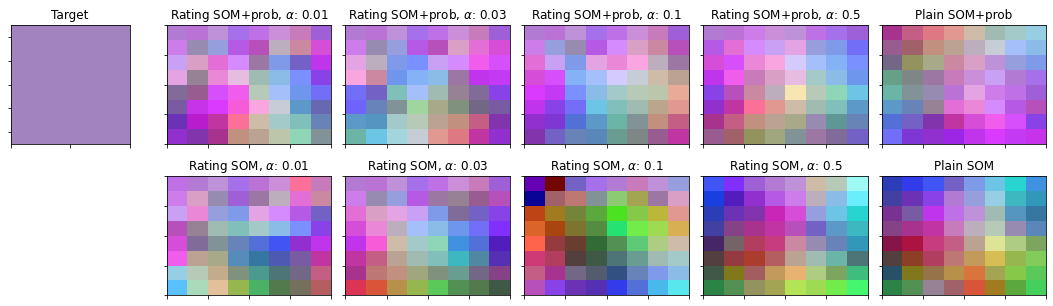

In [21]:
i=0
displayForAlphas("rating",i,evalProc,"",10)
plt.tight_layout()
plt.savefig("img/alphas/alphaExample_"+str(i)+".png", dpi=300)

[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]


<ipython-input-36-451988ae4d1a>:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, numOfVariants, figsize=(figWidth,4.5))


[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03 0.1  0.5 ]
[0.01 0.03

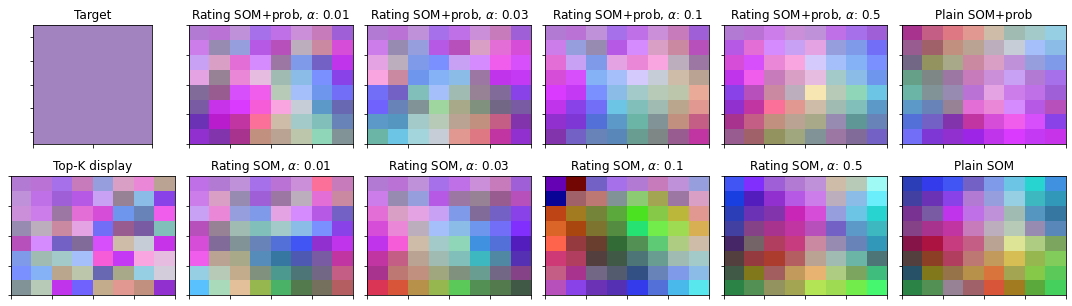

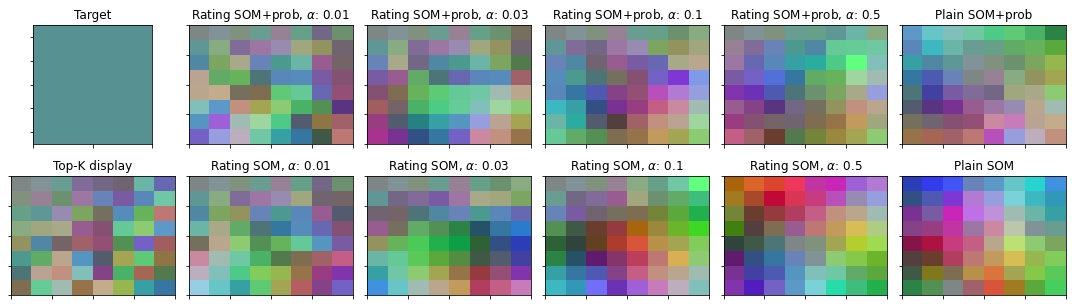

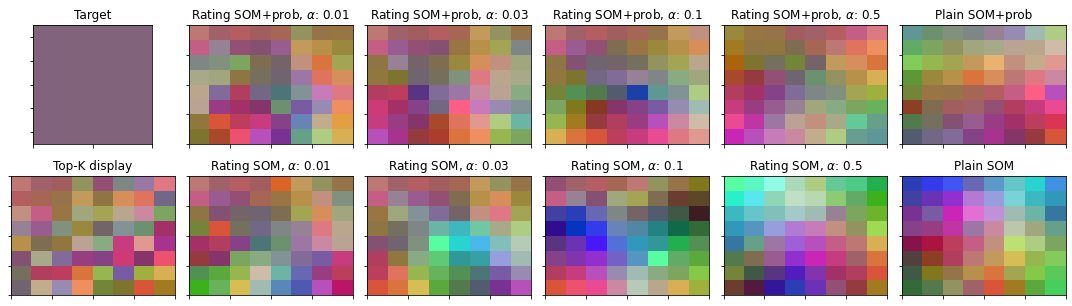

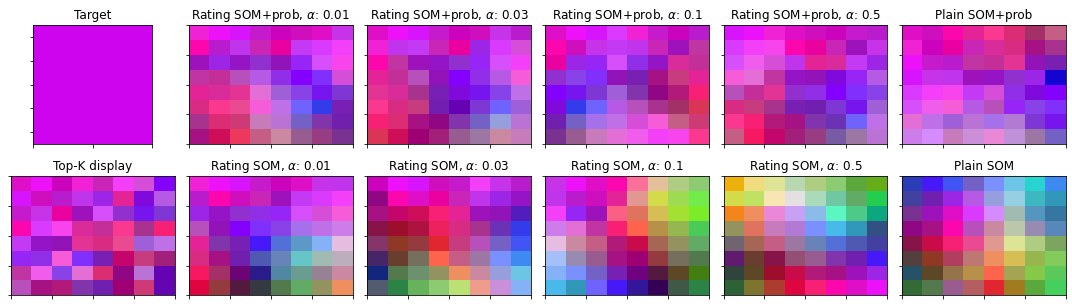

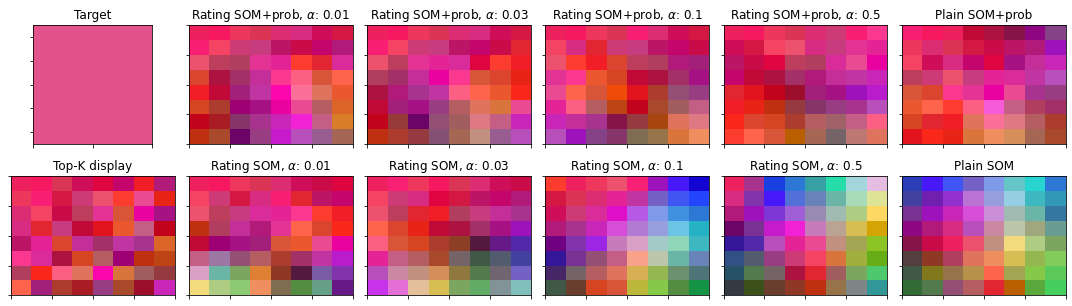

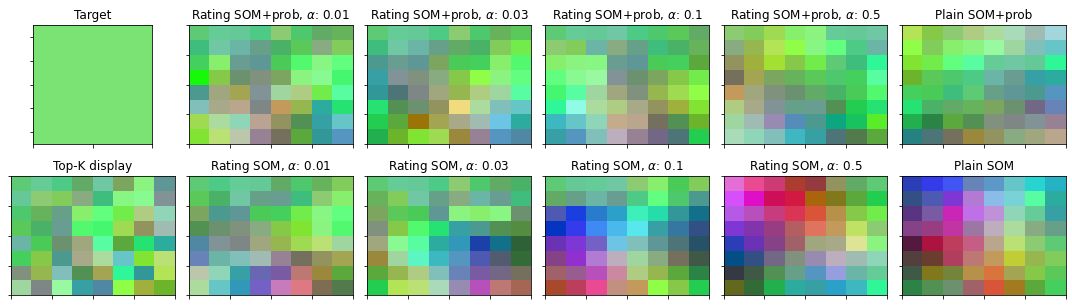

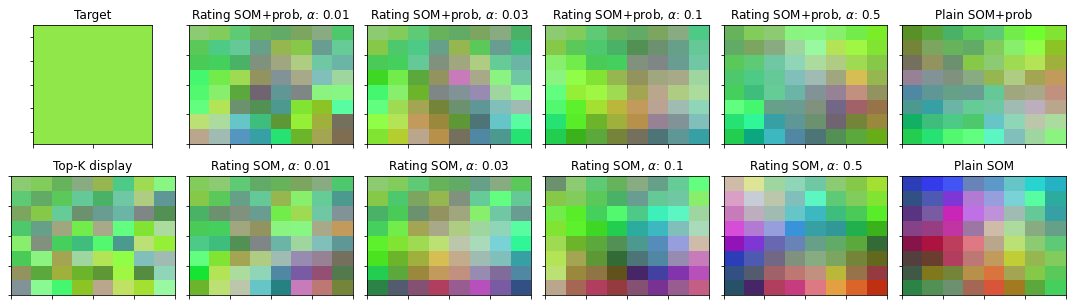

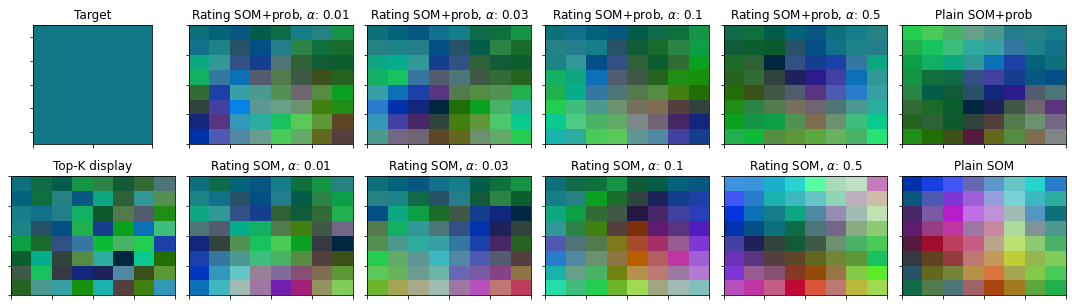

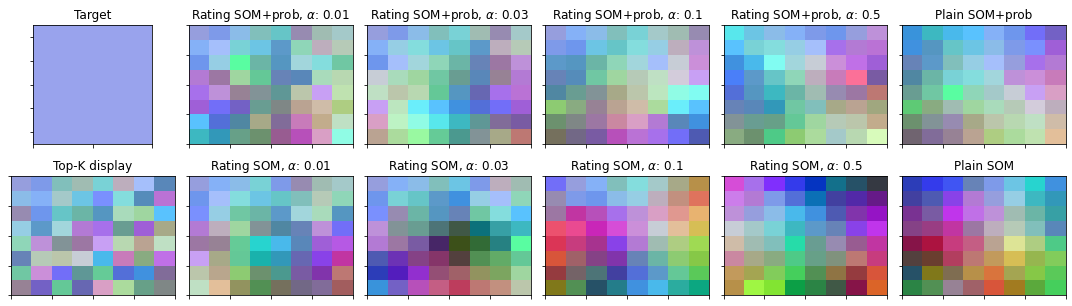

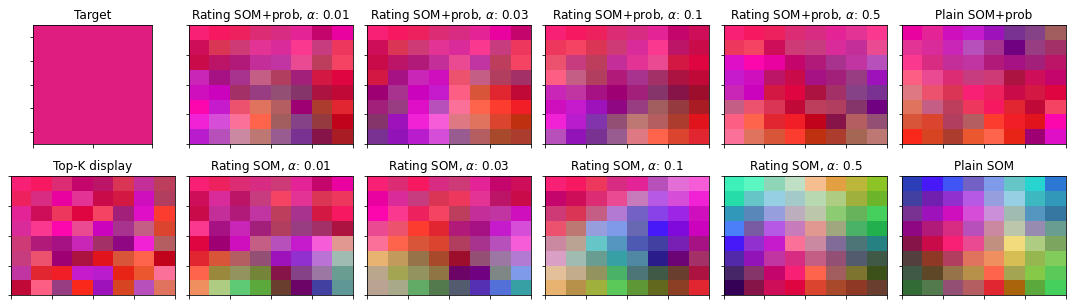

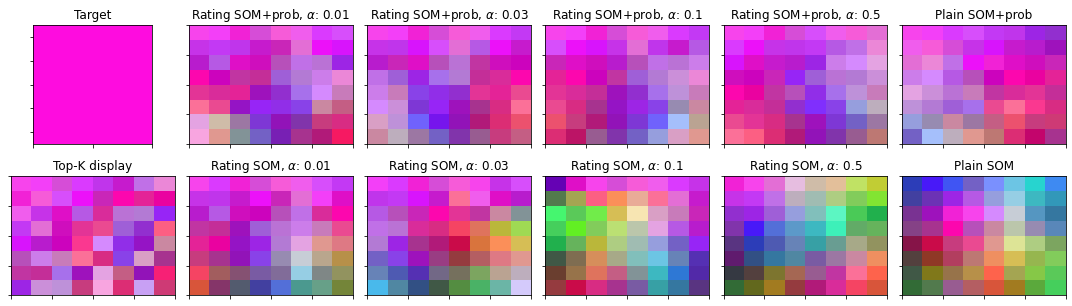

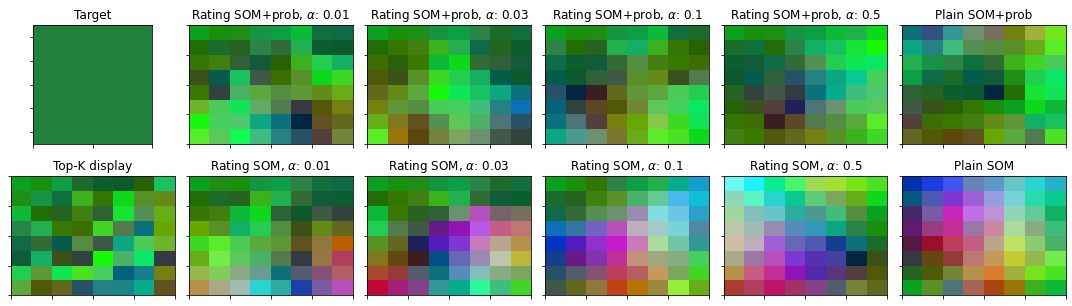

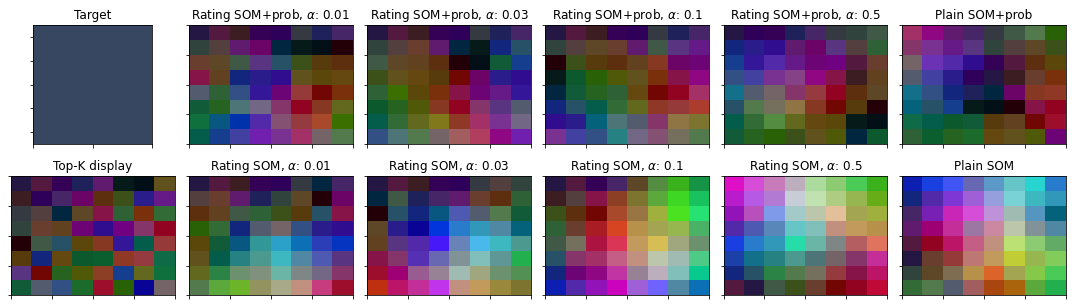

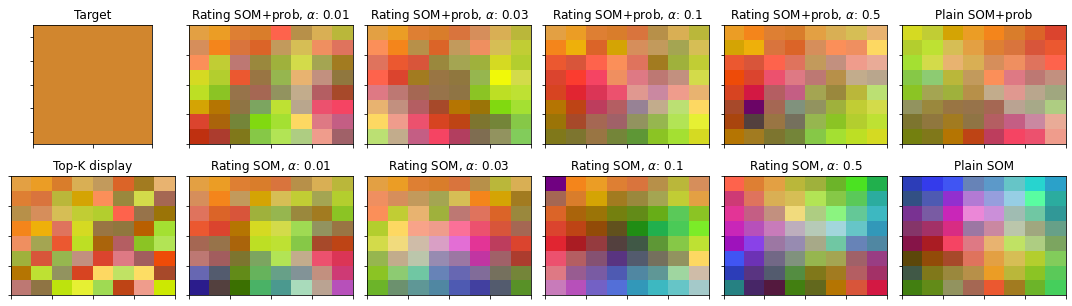

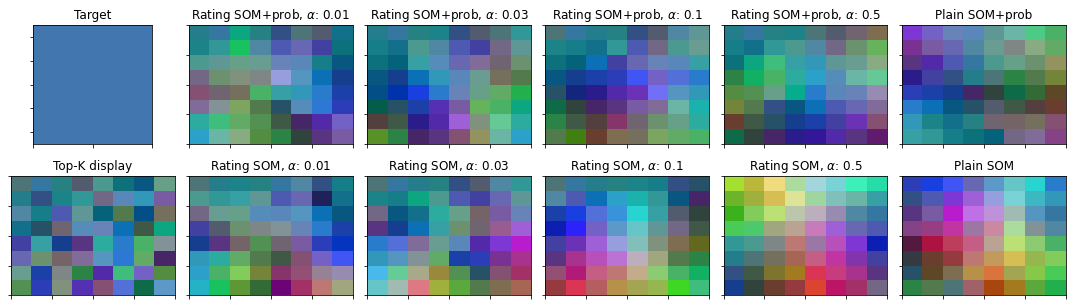

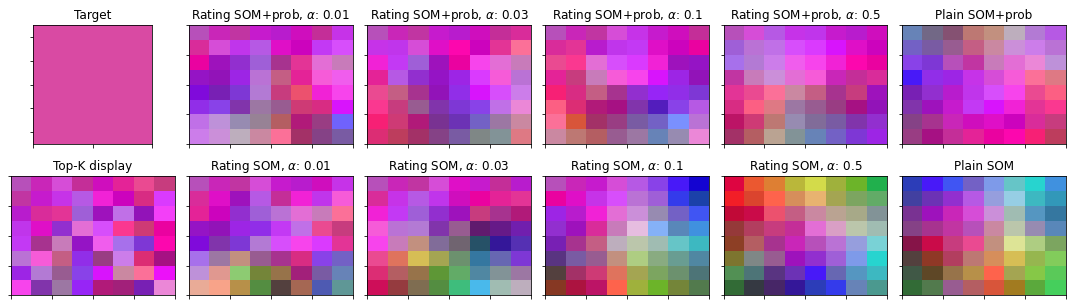

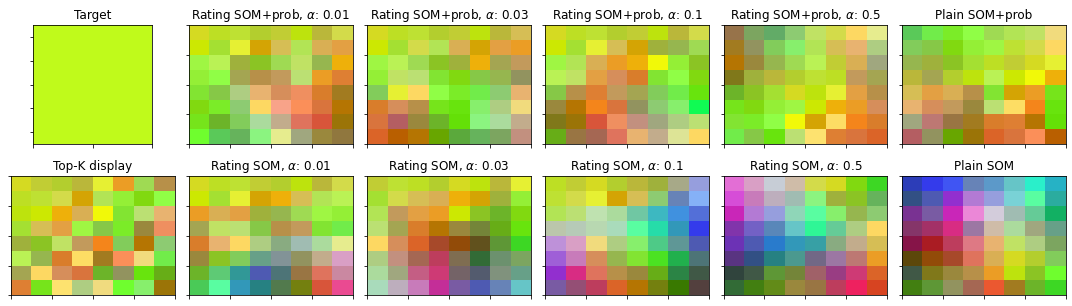

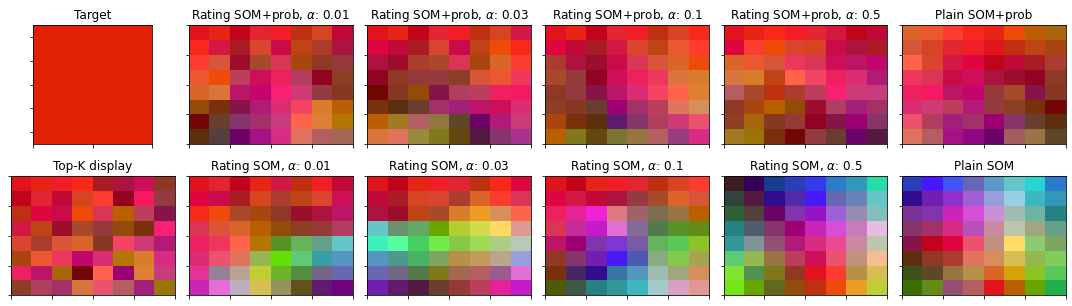

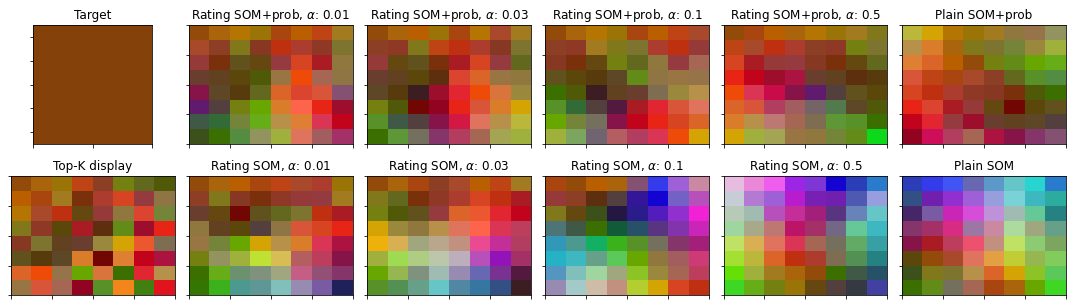

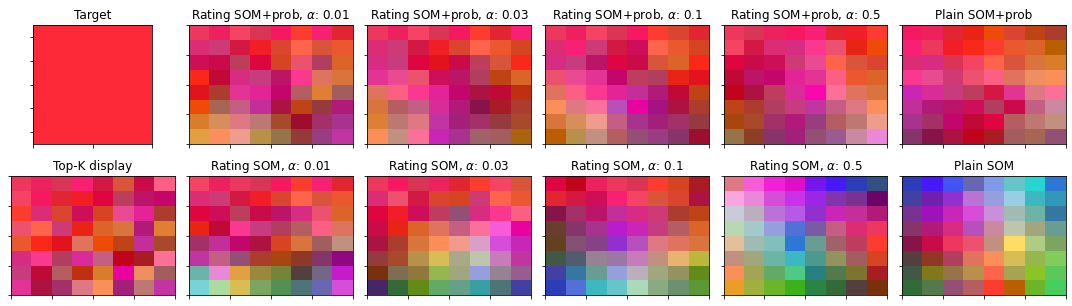

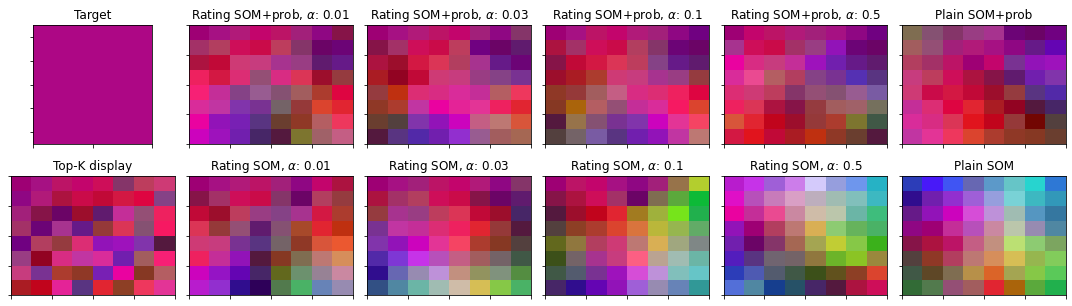

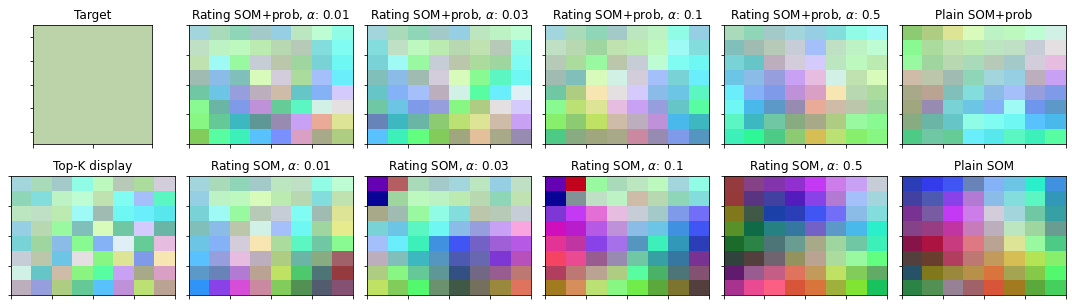

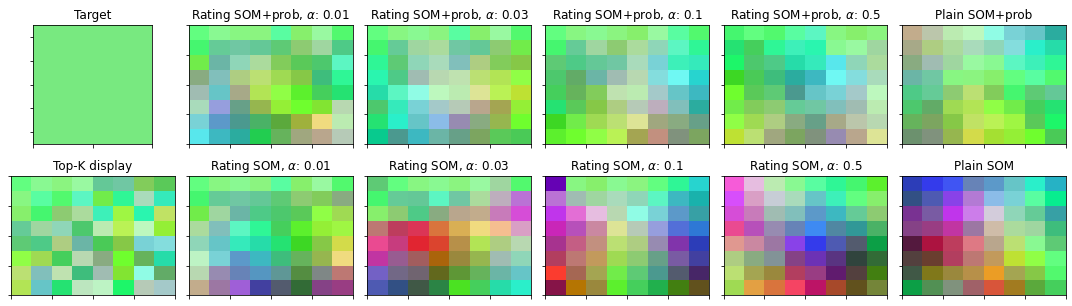

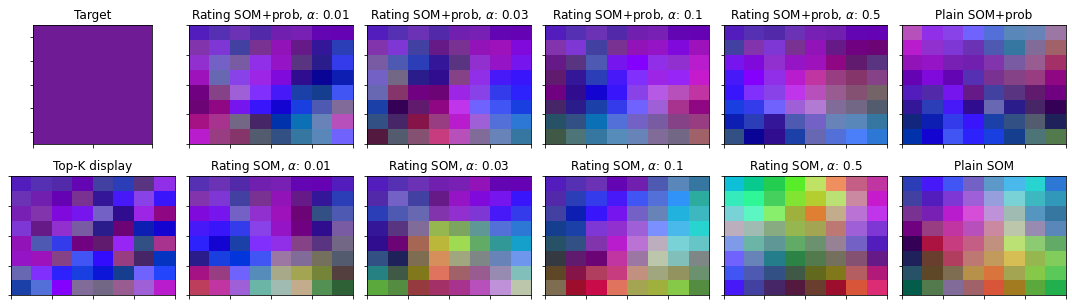

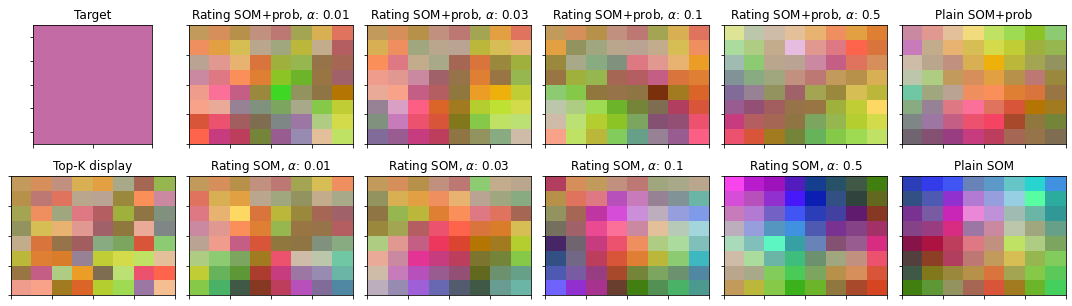

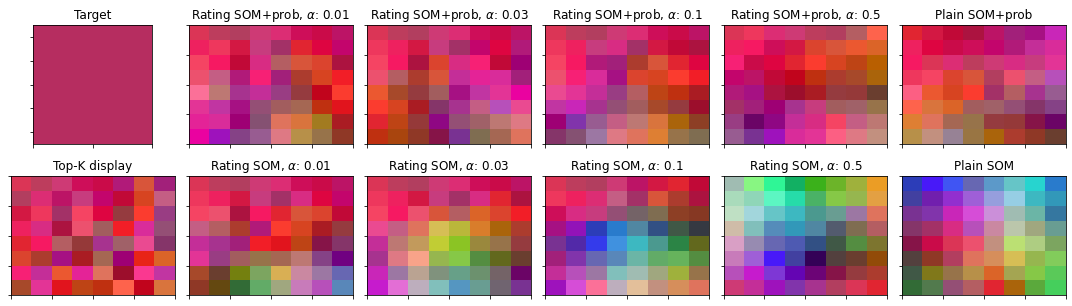

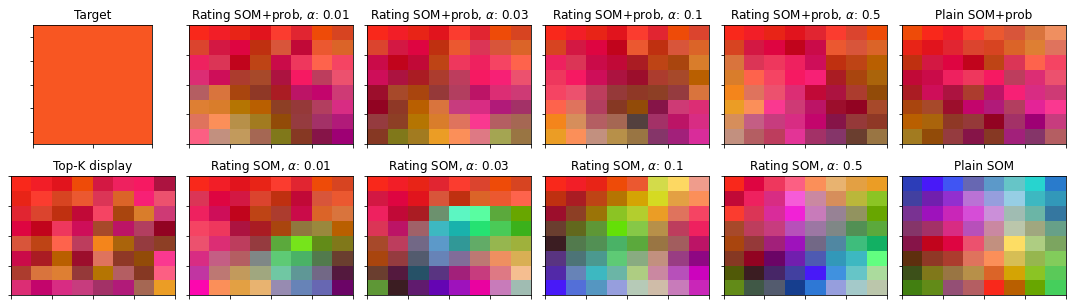

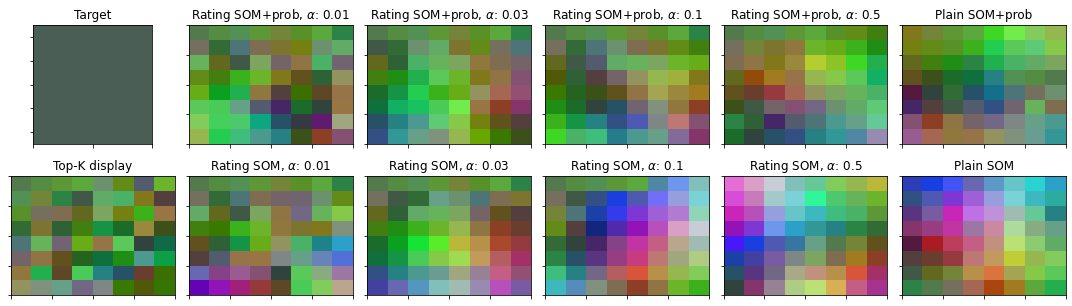

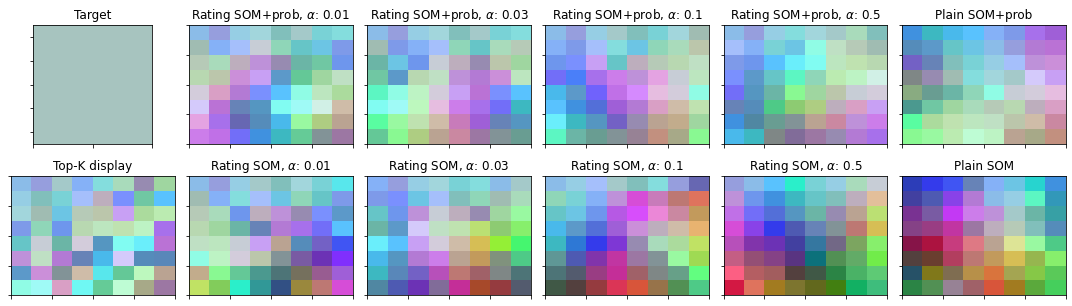

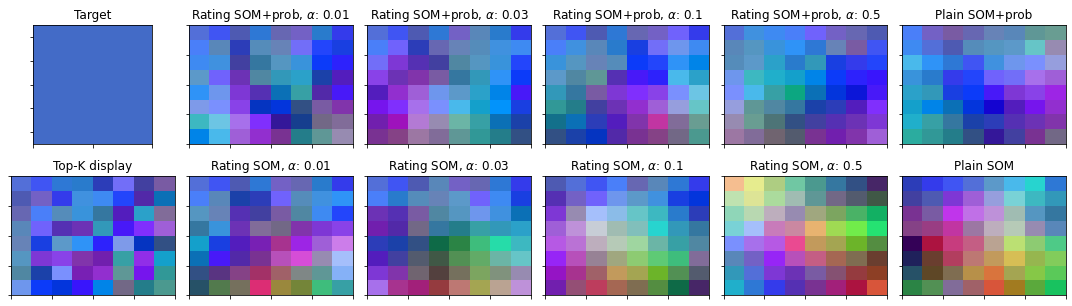

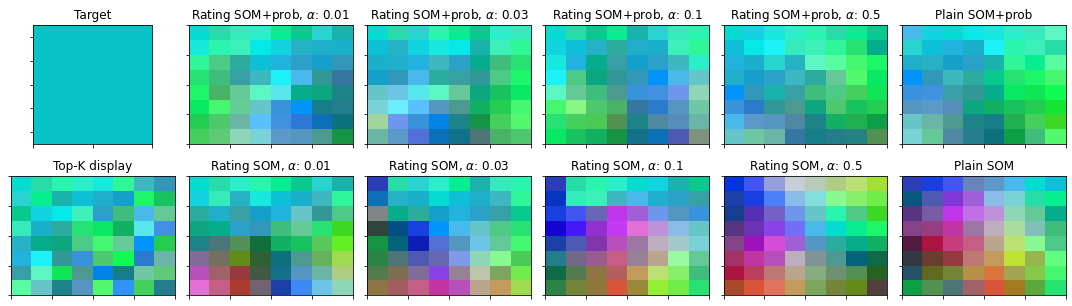

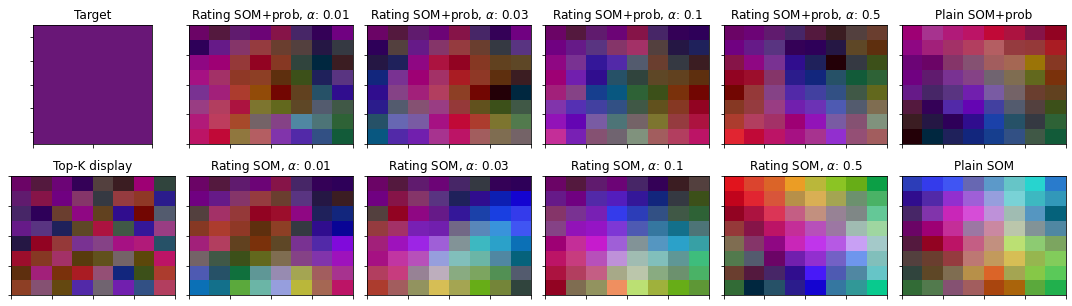

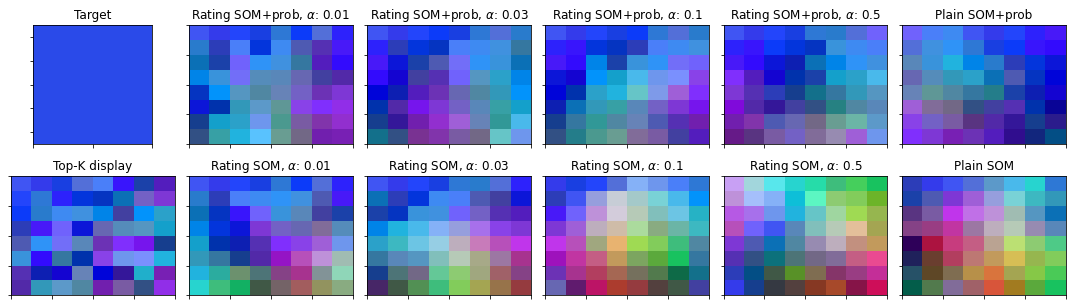

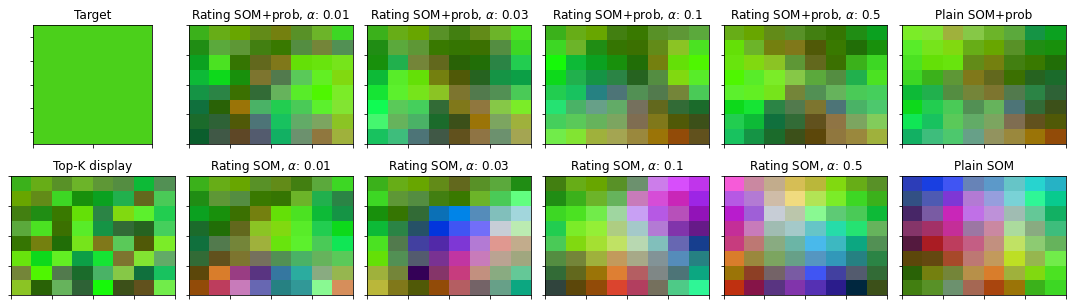

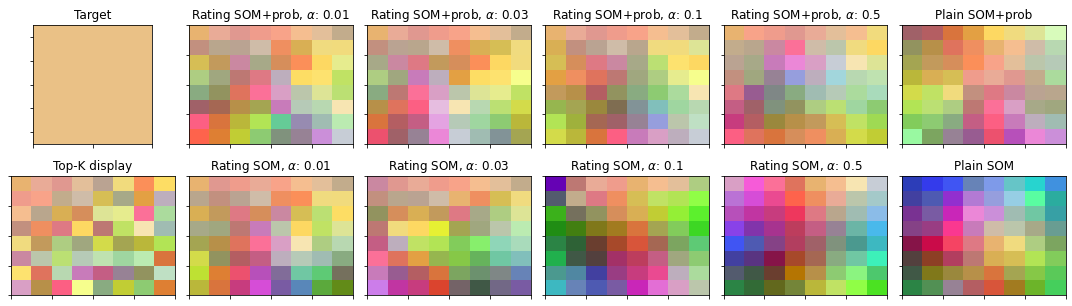

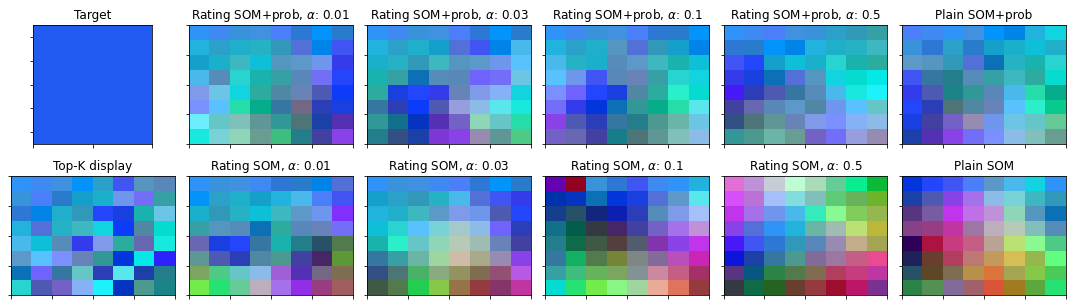

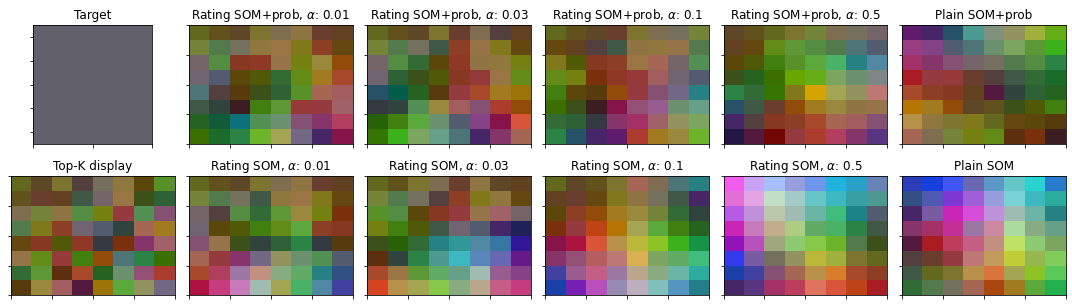

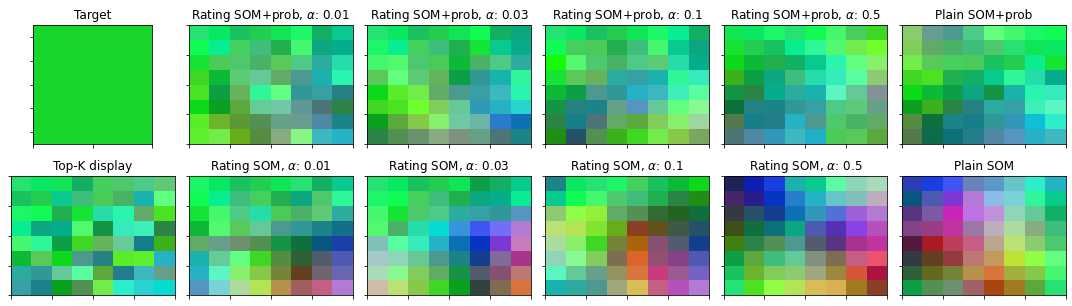

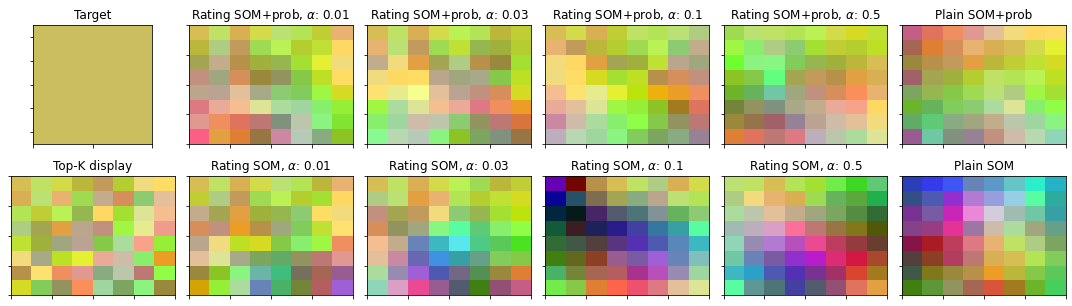

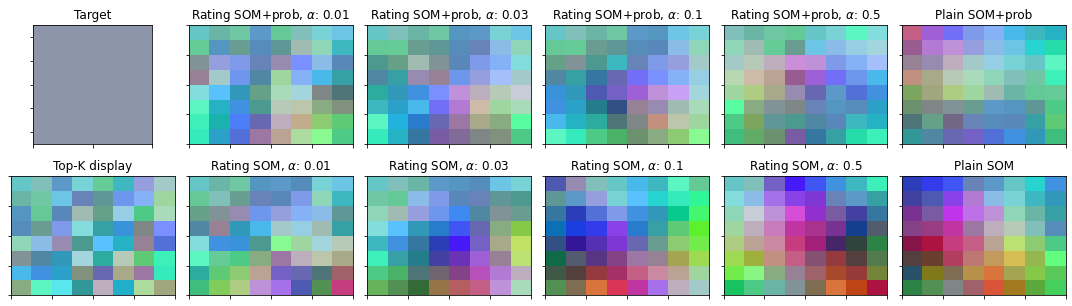

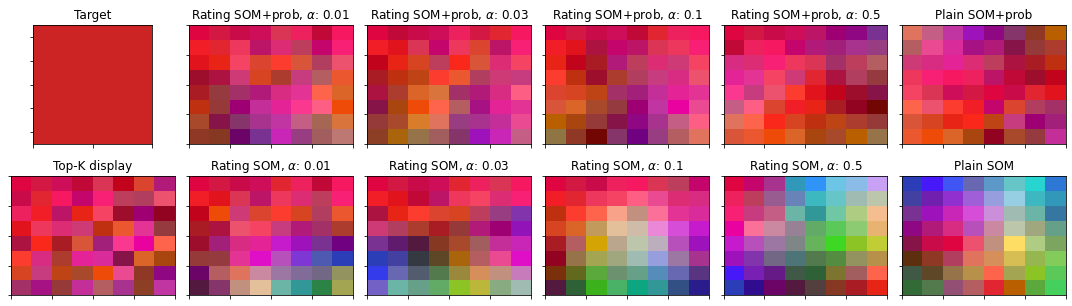

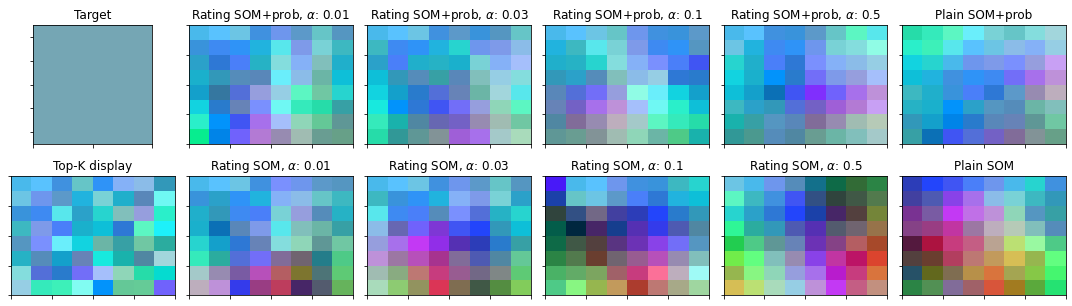

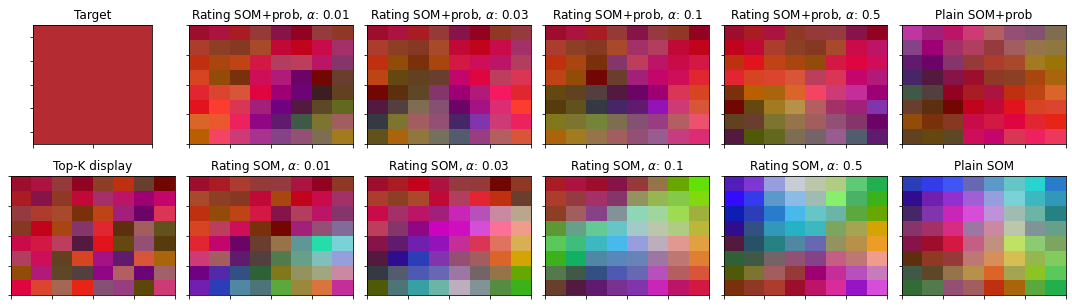

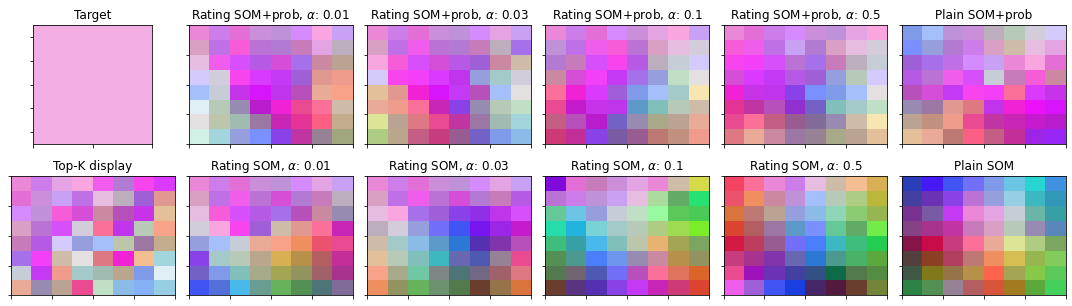

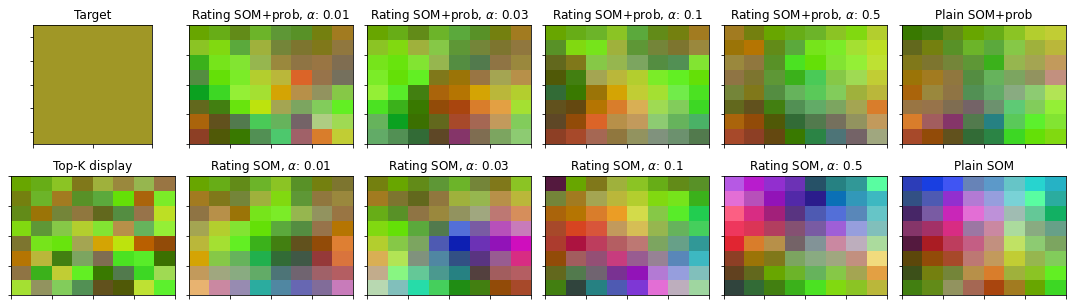

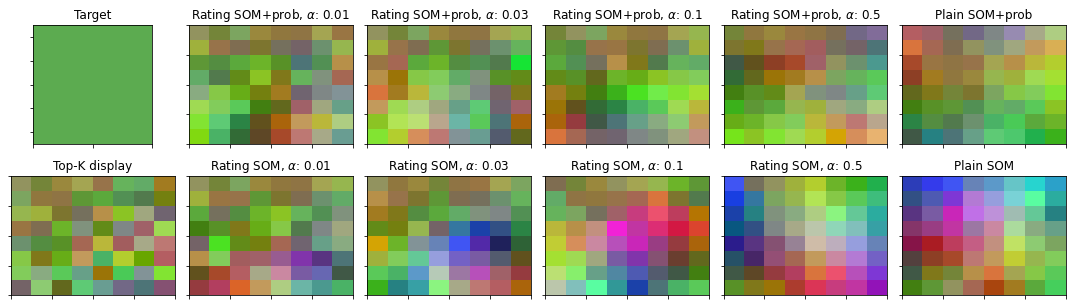

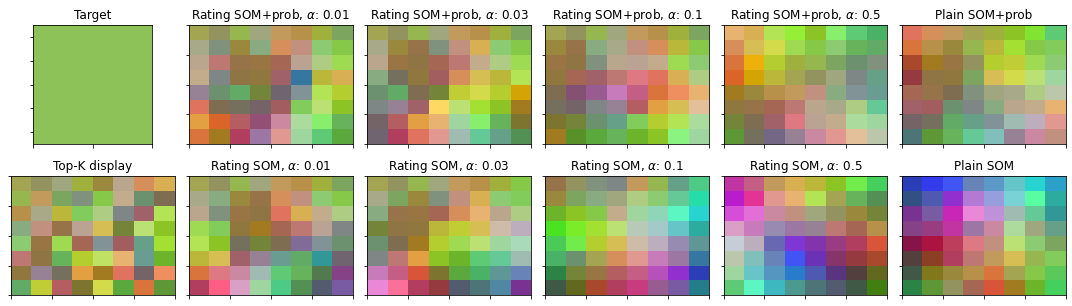

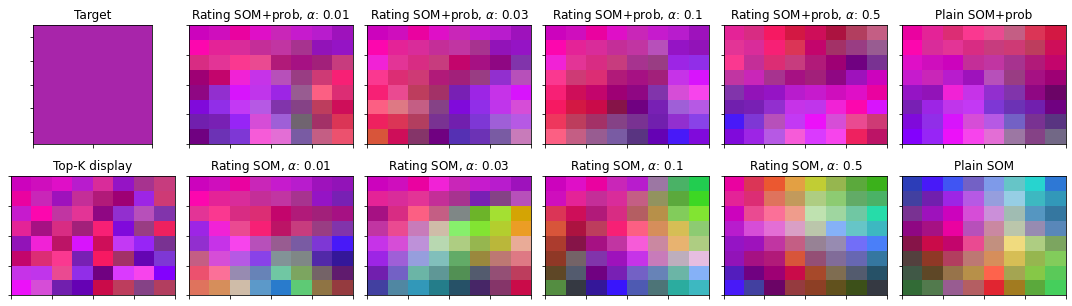

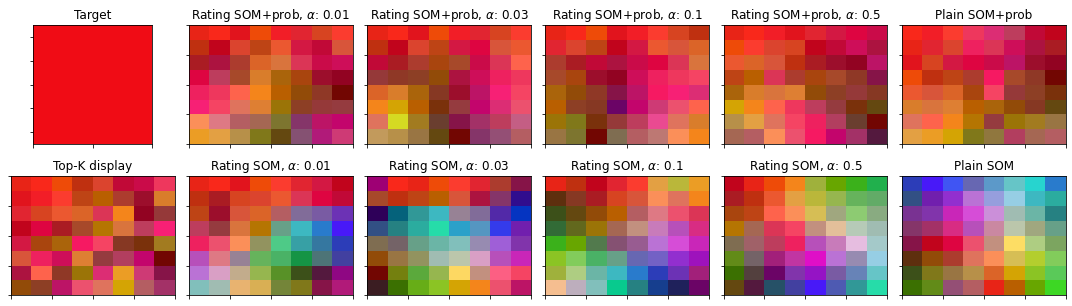

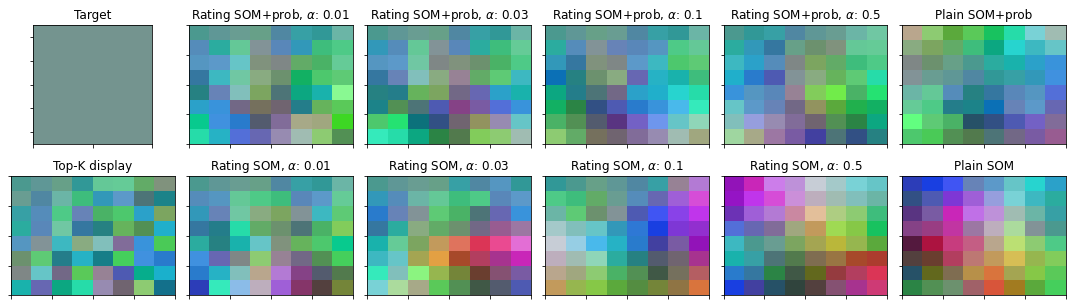

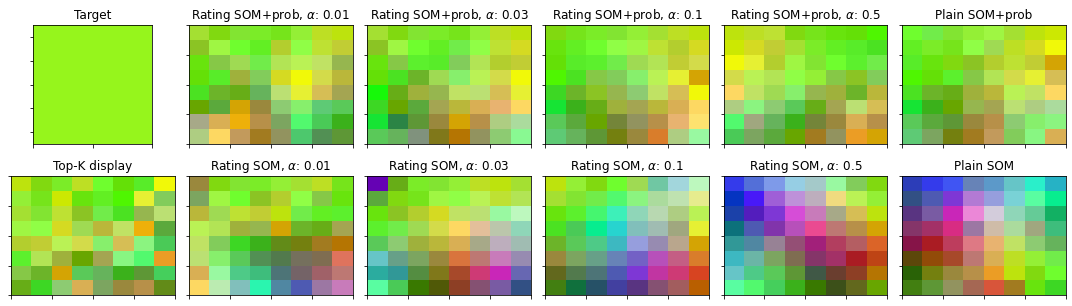

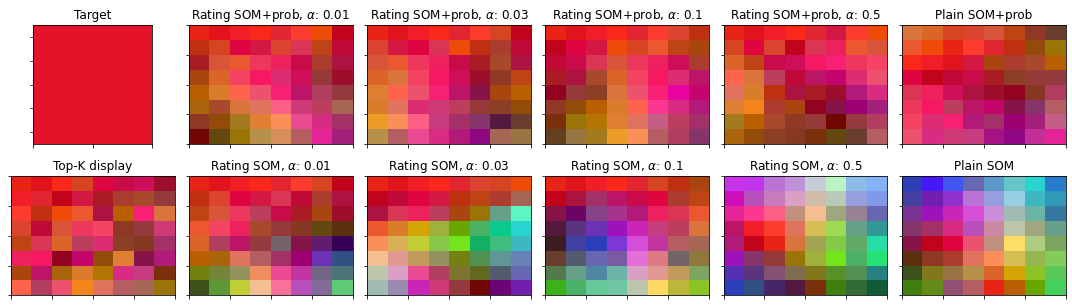

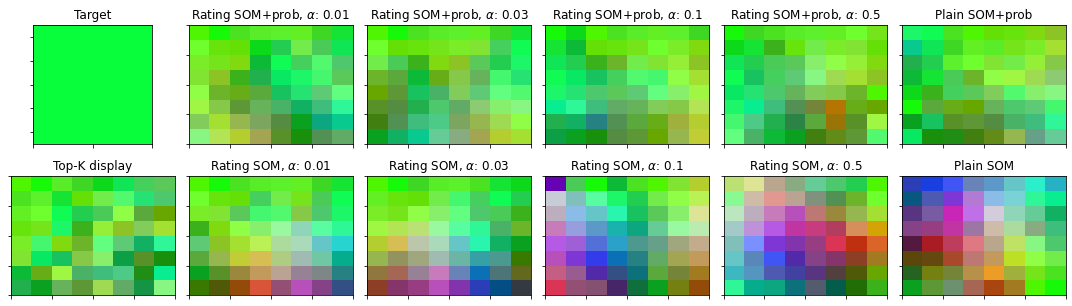

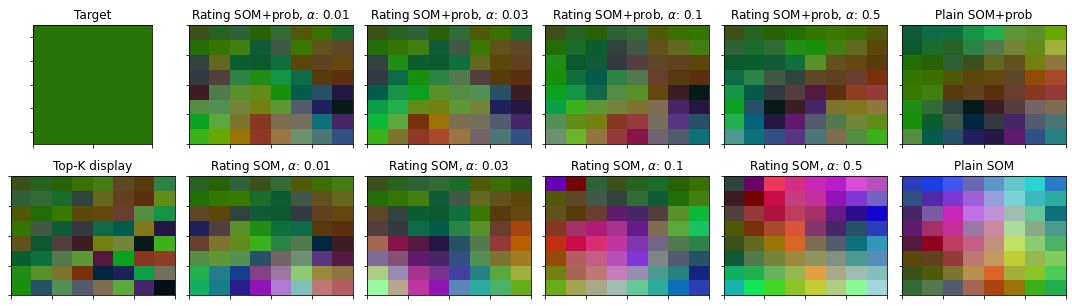

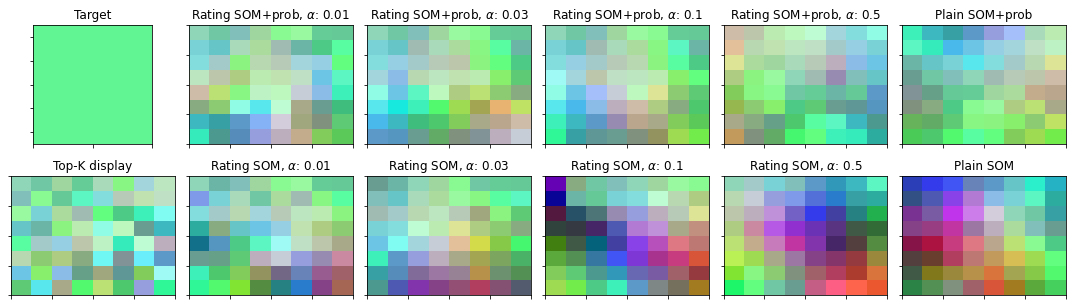

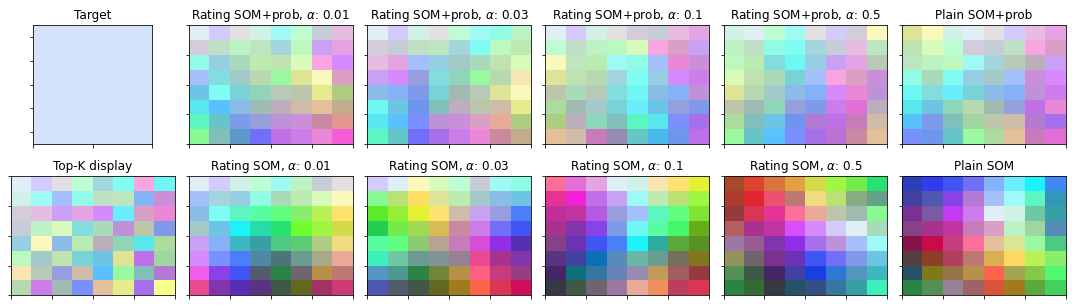

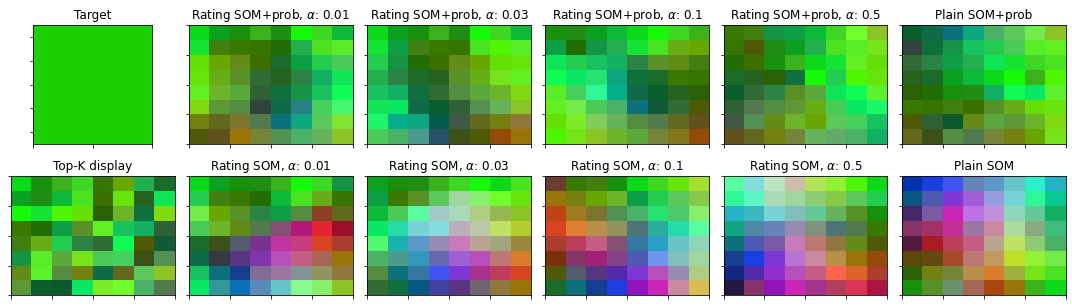

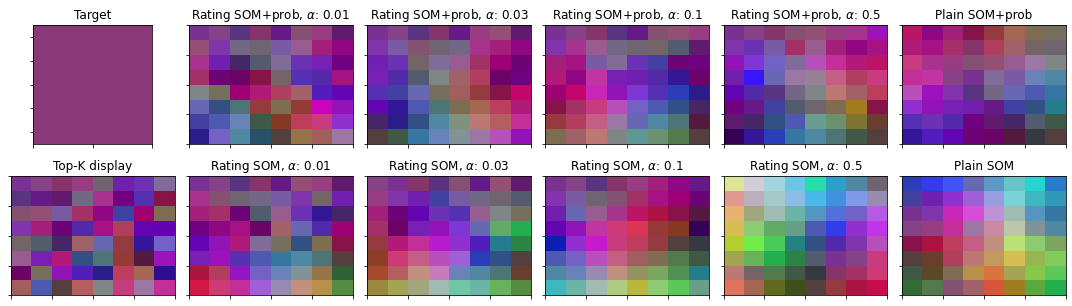

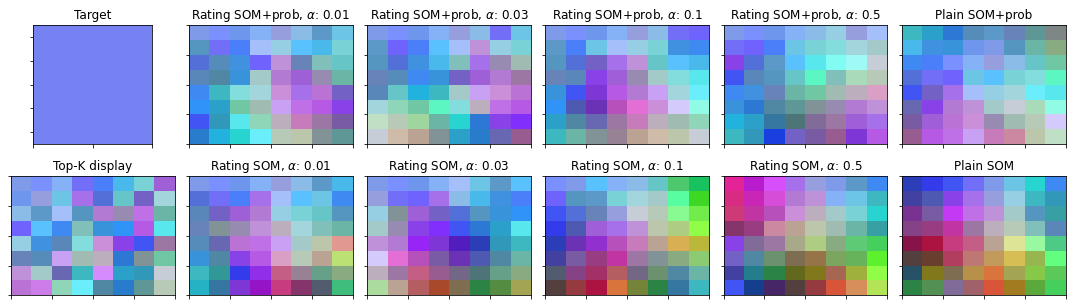

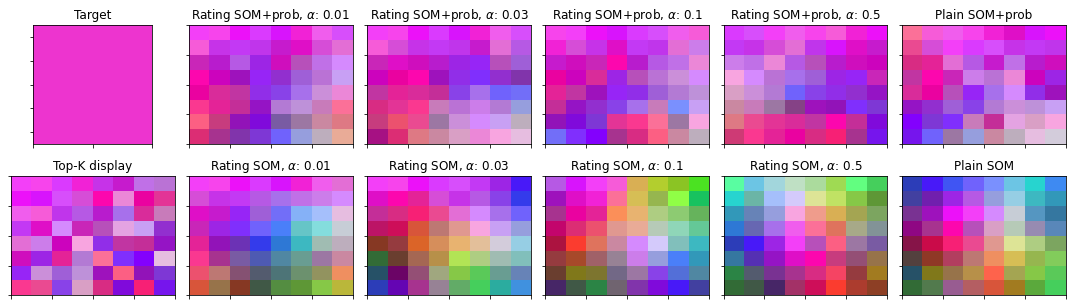

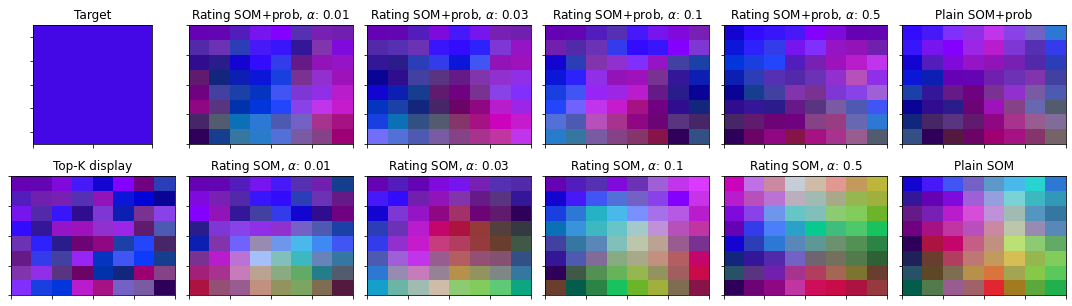

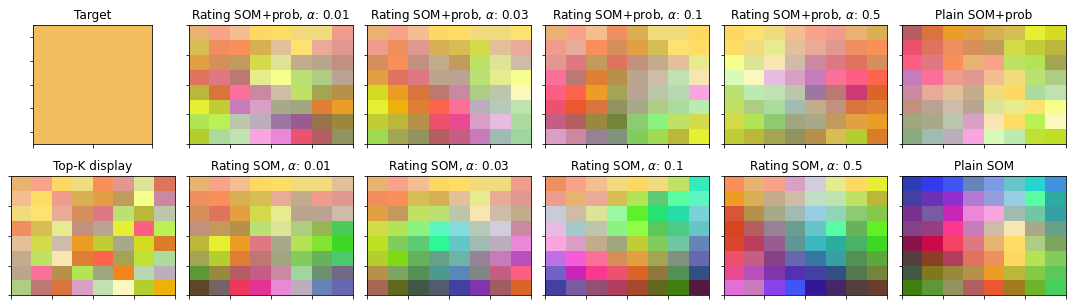

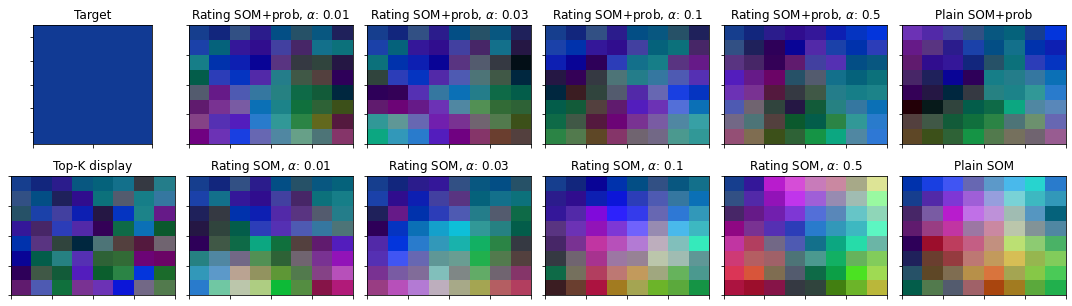

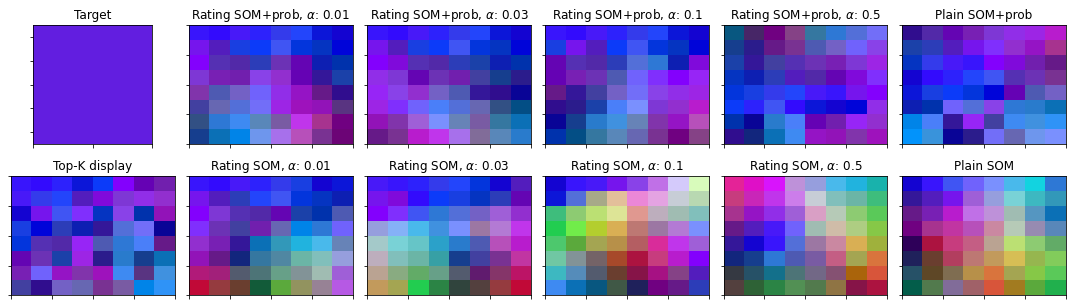

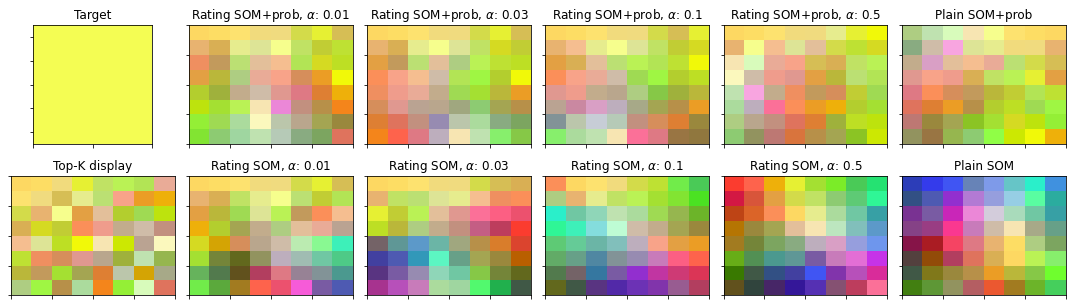

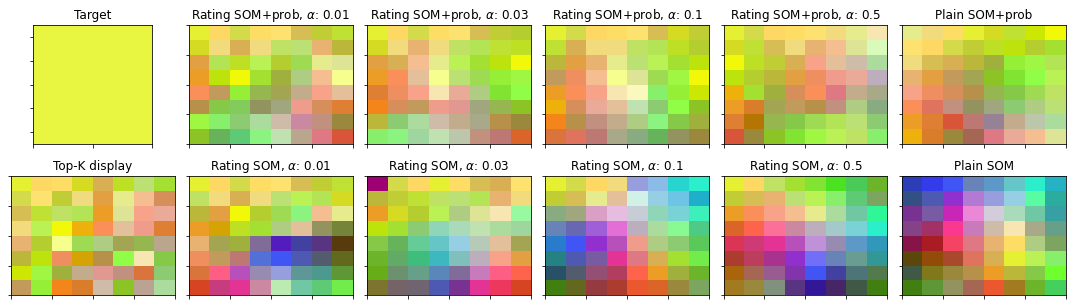

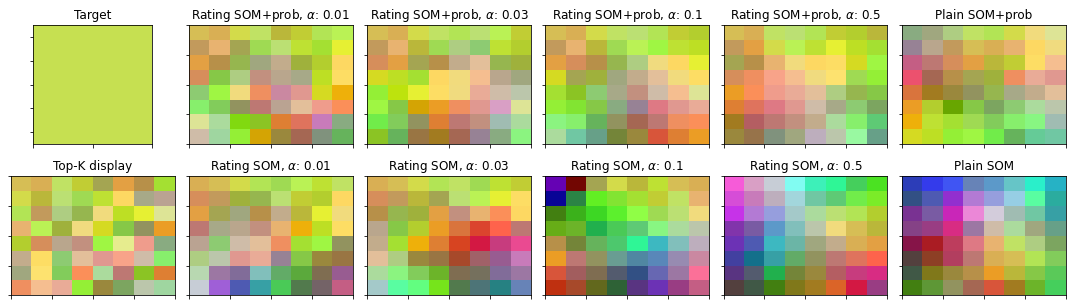

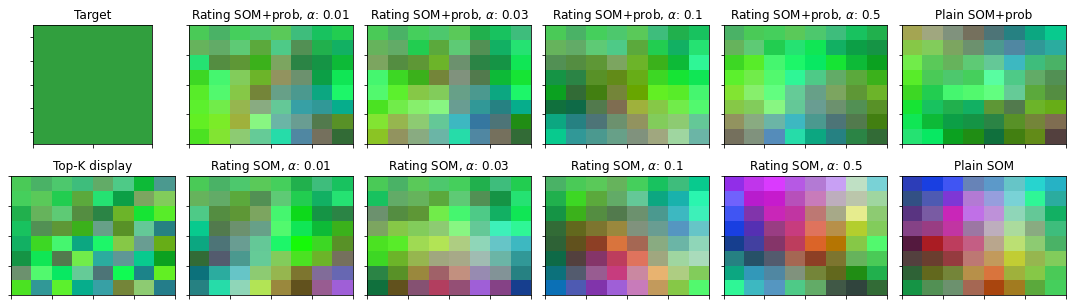

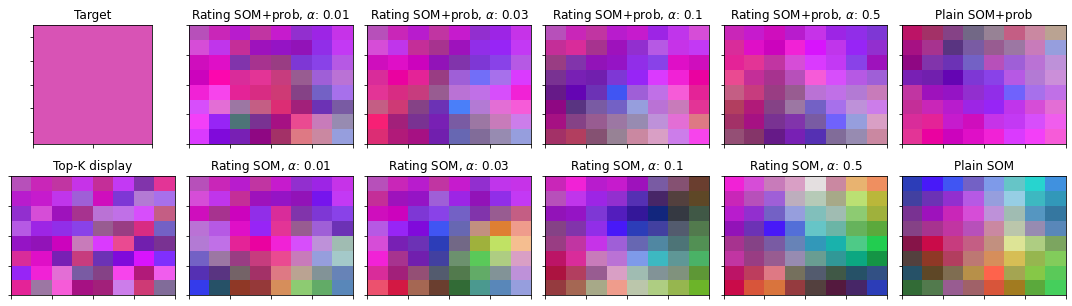

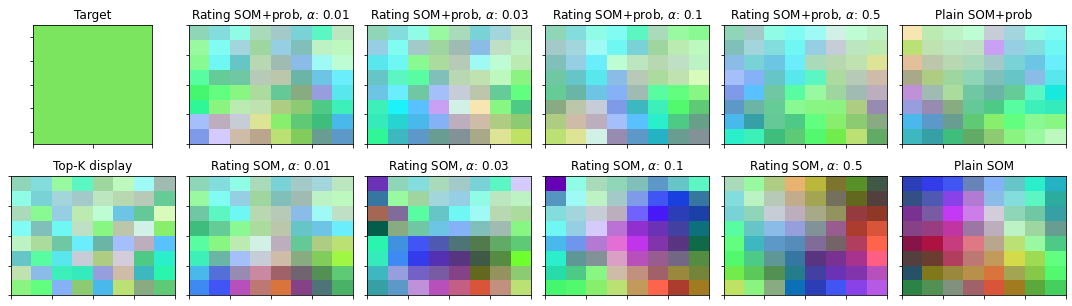

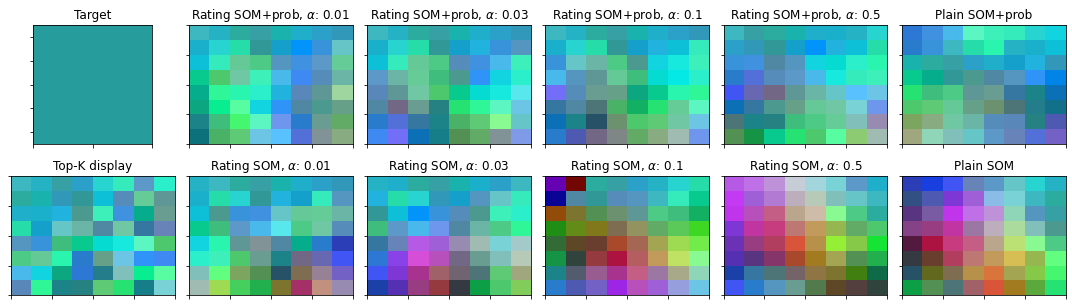

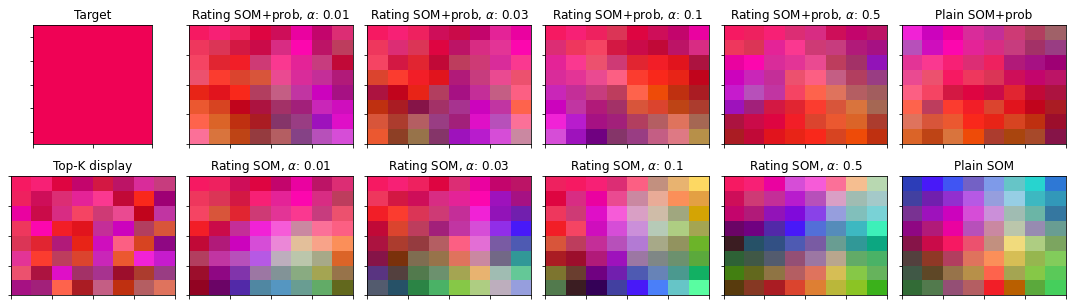

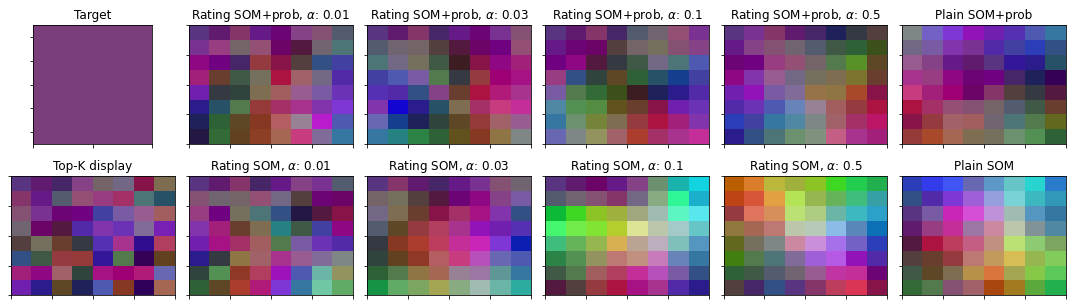

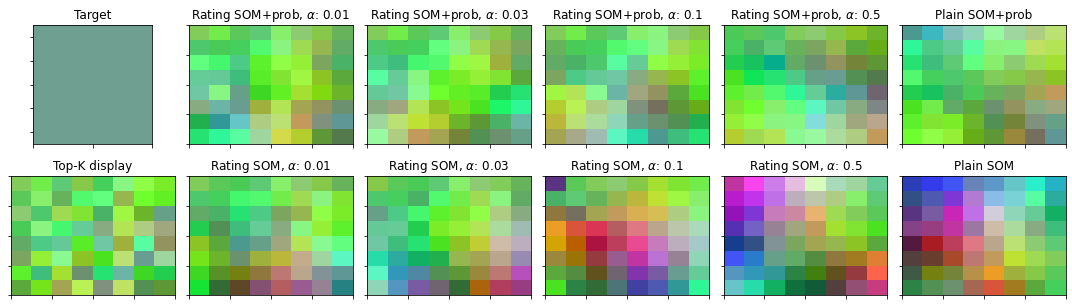

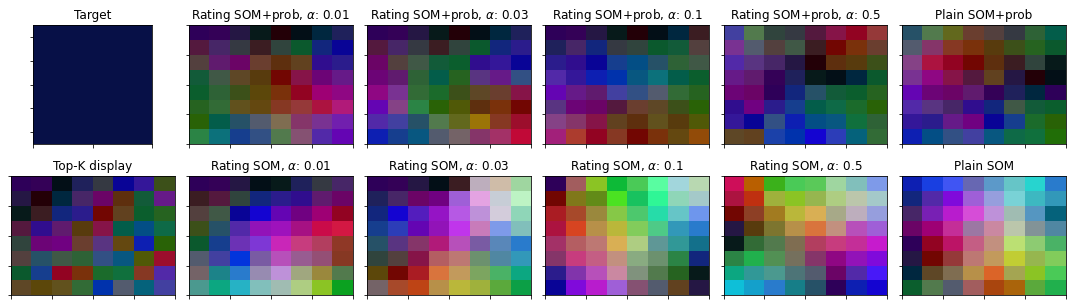

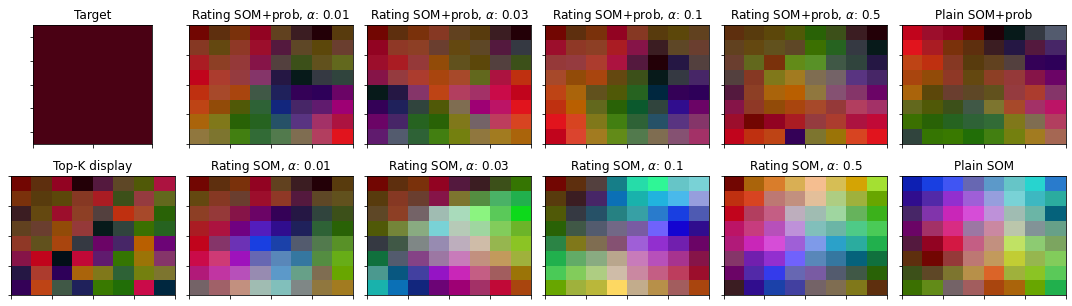

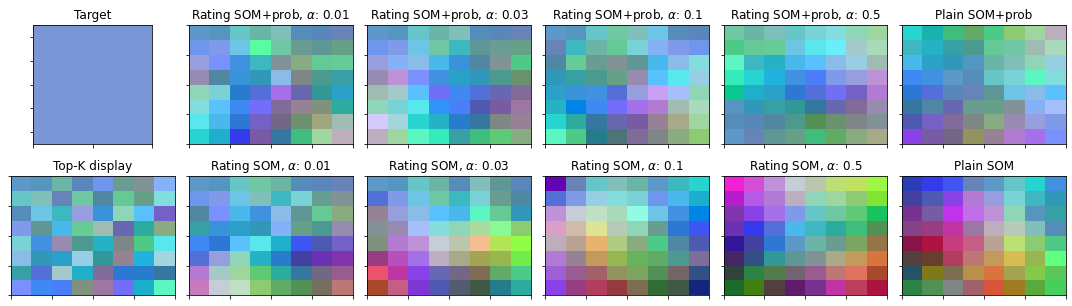

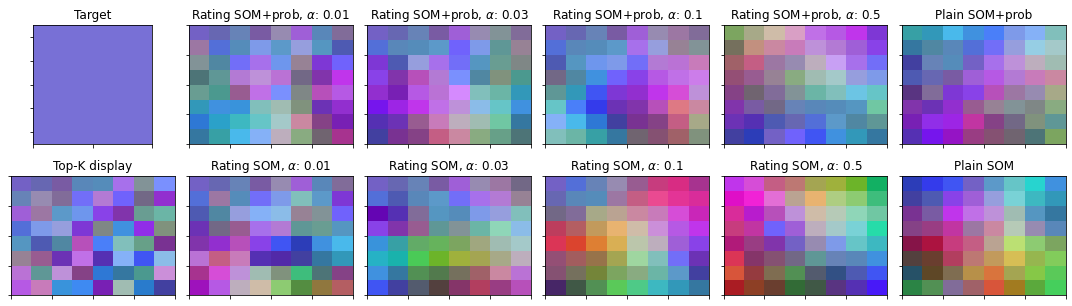

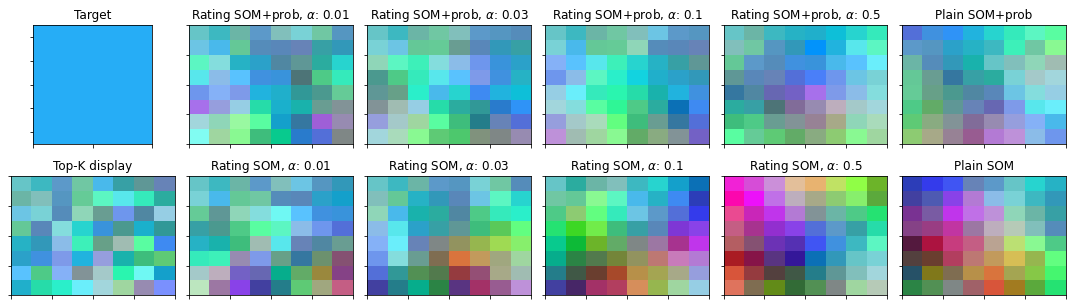

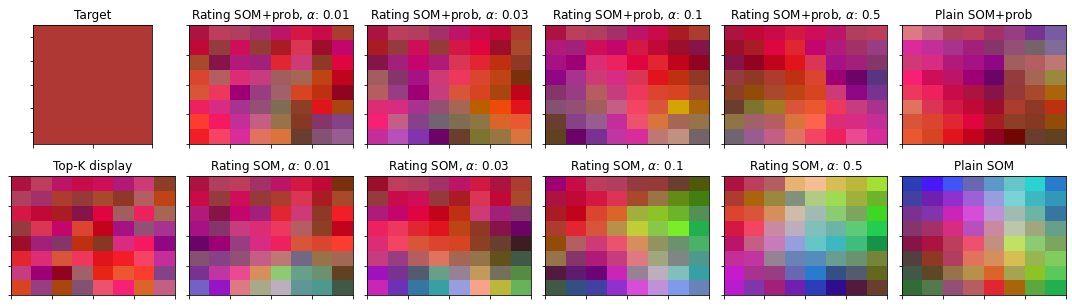

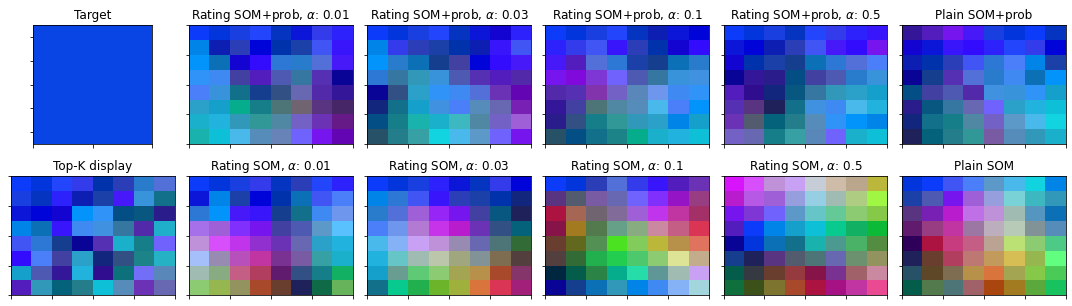

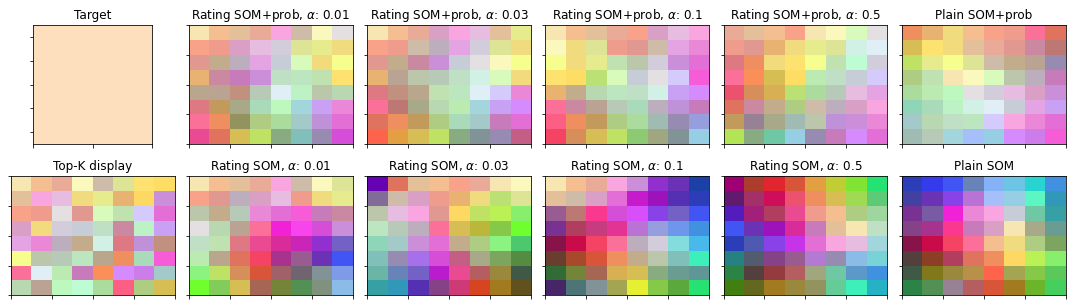

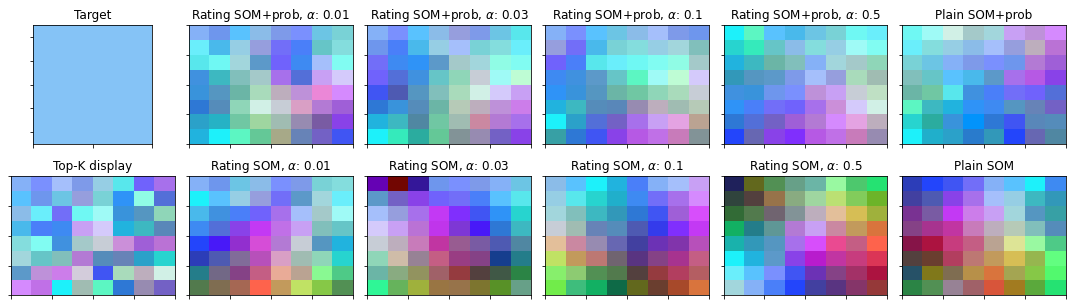

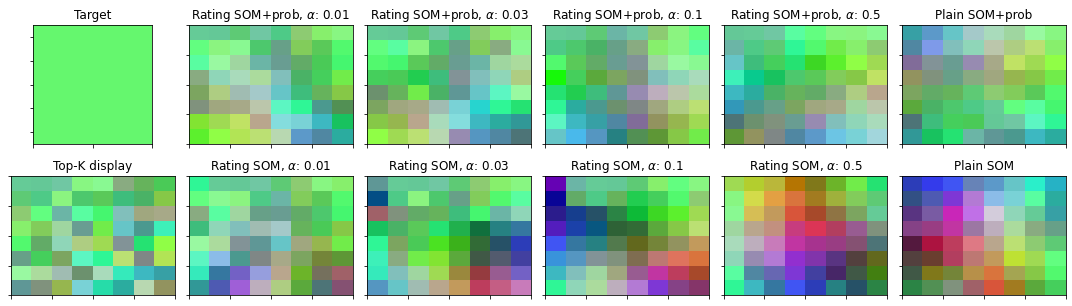

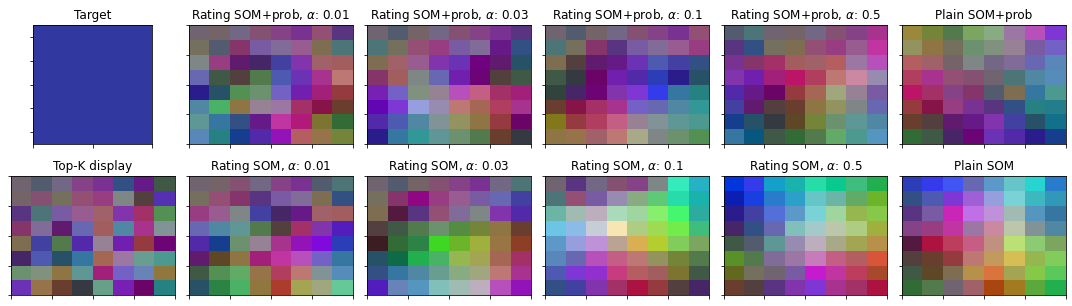

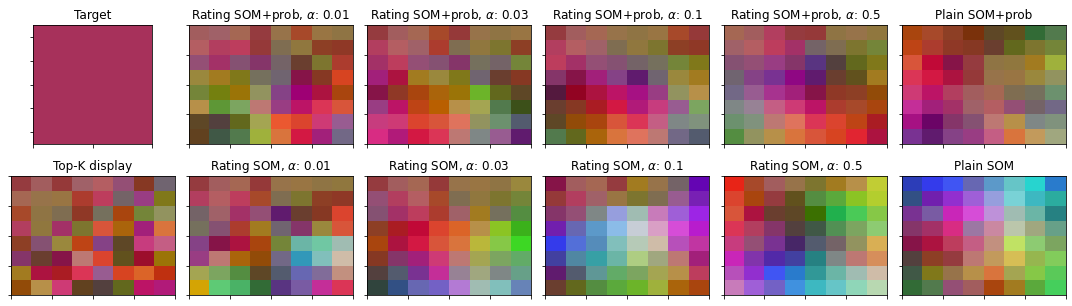

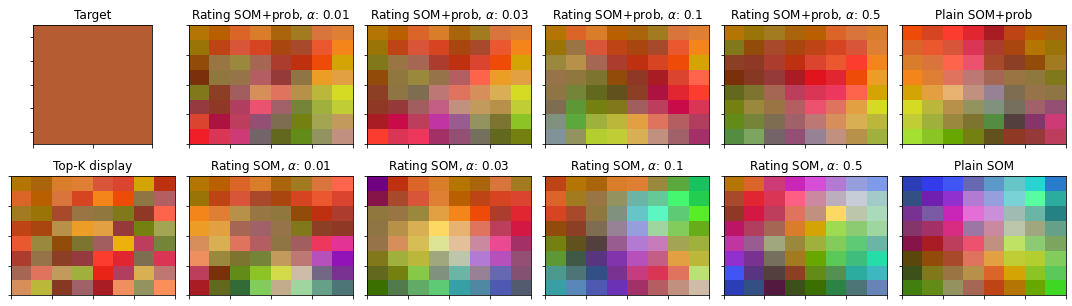

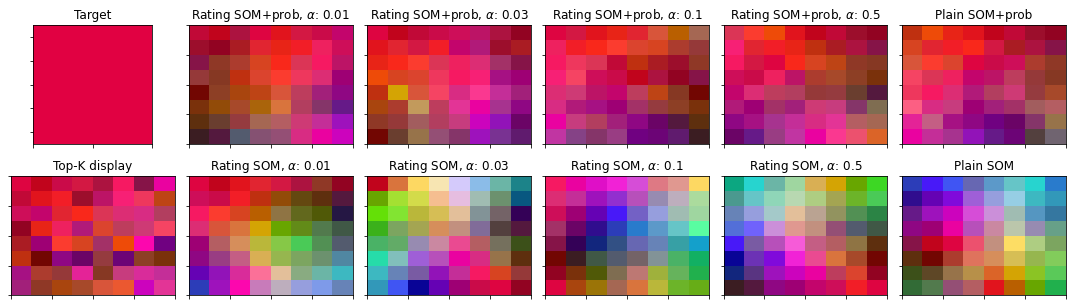

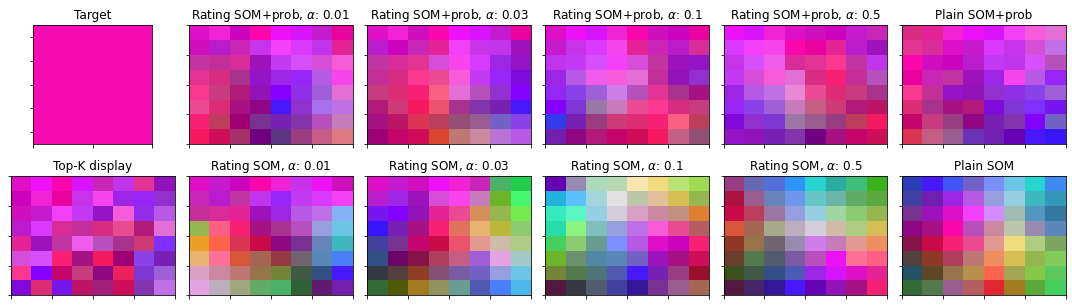

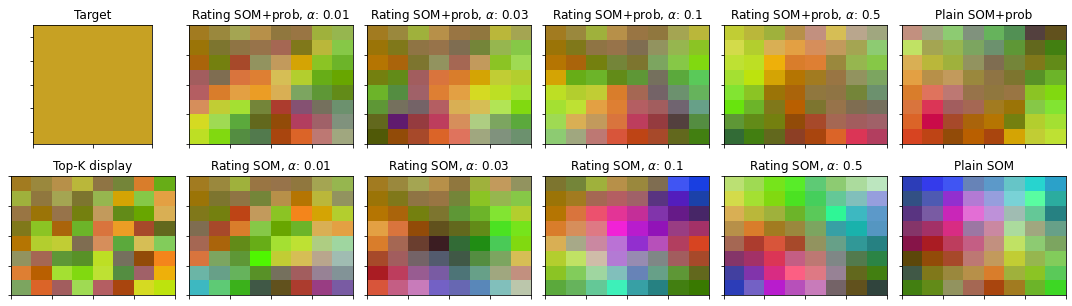

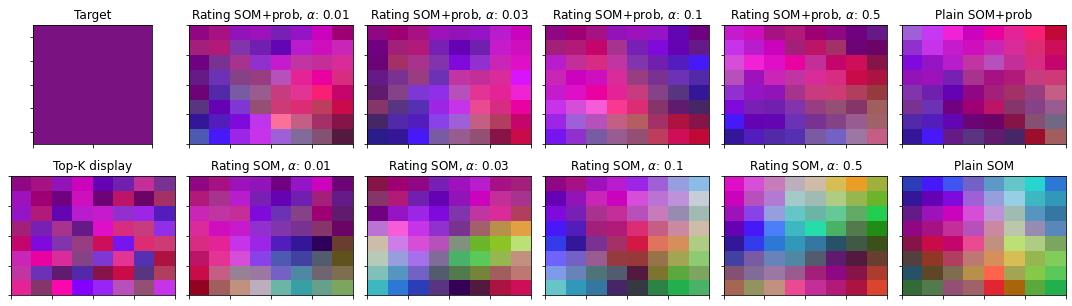

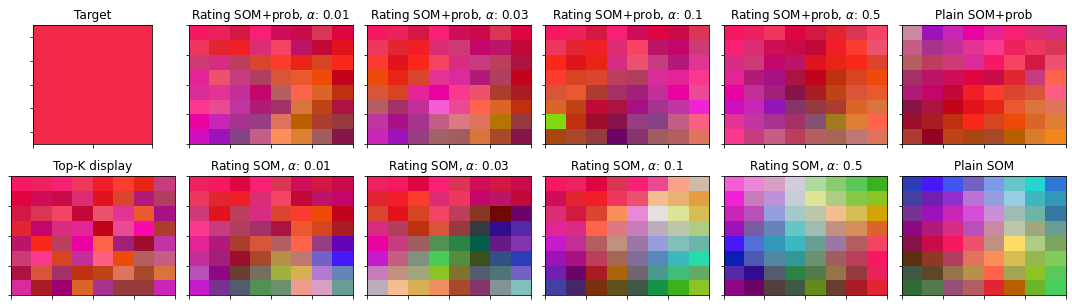

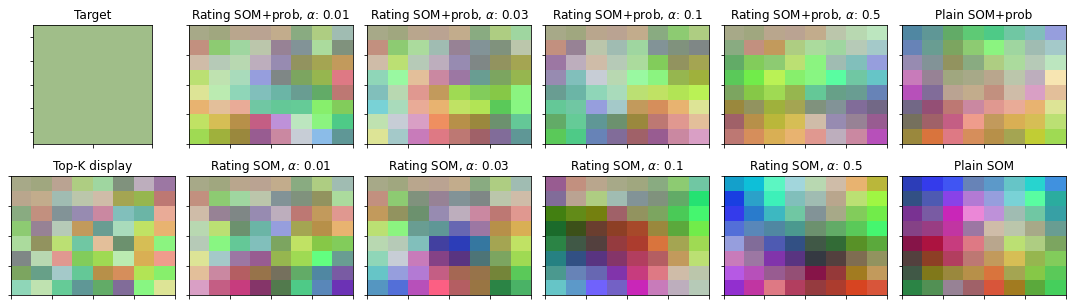

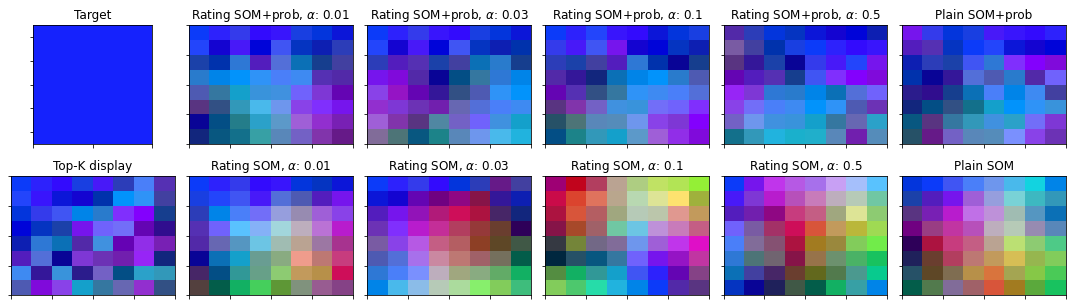

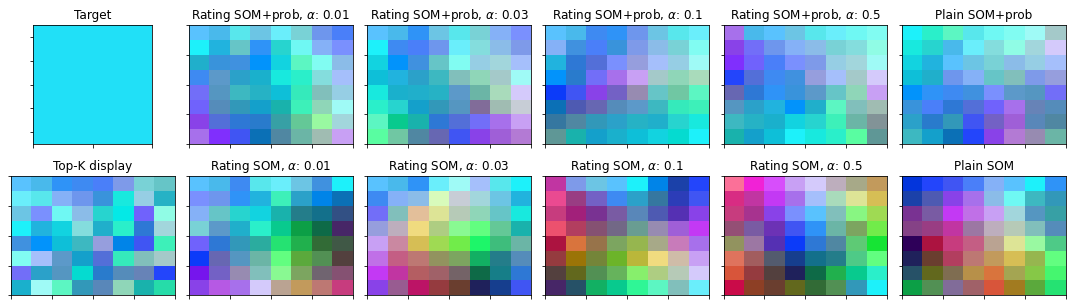

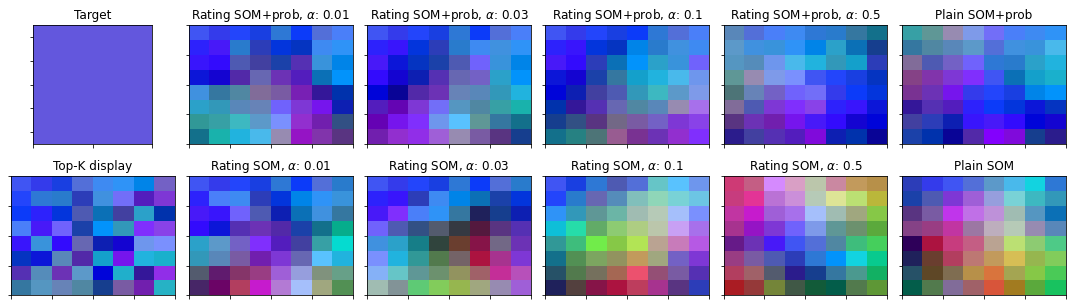

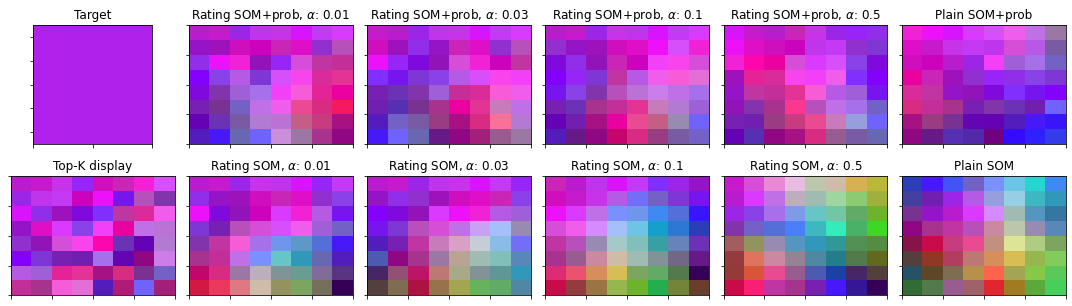

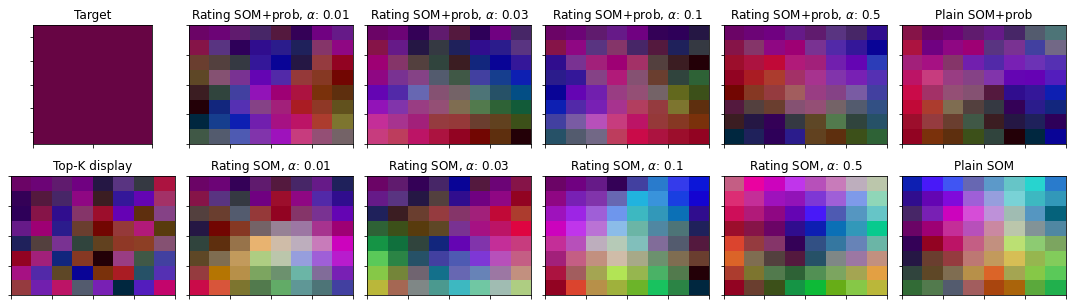

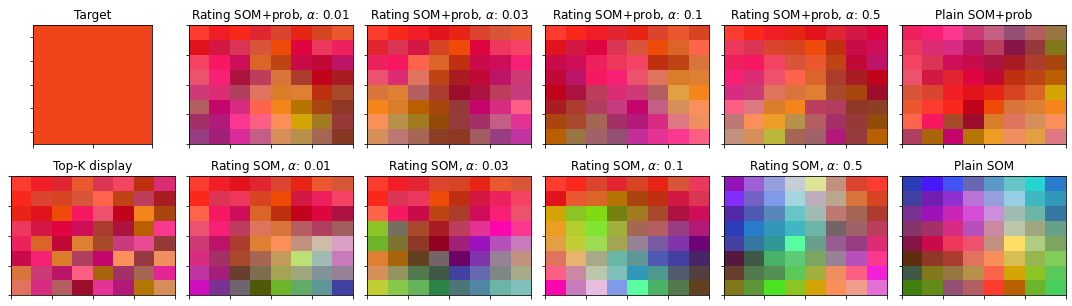

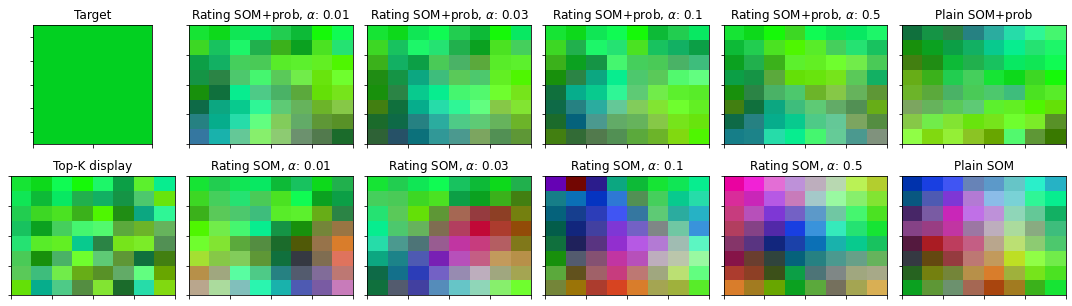

In [40]:
for i in range(100):
    displayForAlphas("rating",i,evalProc,"",10)
    plt.tight_layout()
    plt.savefig("img/alphas/alphaExample_"+str(i)+".png", dpi=300)

In [13]:
def displayForMethods(som_variants, item, evalProc, titleText):
    #som_variant is a tuple here
    positions = ["r"+str(i) for i in list(range(1,evalProc.SOM_dim**2+1))] 
    target = evalProc.testTargets[item]

    numOfVariants = len(som_variants)
    numOfVariantsX = numOfVariants 
    numOfVariantsY = 1    
    



    
    figWidth = 1+2.5*numOfVariantsX
    widthRatios = [1]+[3]*numOfVariantsX
    fig, ax = plt.subplots(1, numOfVariantsX+1, figsize=(figWidth,2.5), gridspec_kw={'width_ratios': widthRatios}) 

    ax[0].imshow(evalProc.testTargets[item].reshape(1,-1,3))
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[0].set_title("Target")
    ax[0].set_anchor("N")
    
    for i,variant in enumerate(som_variants): 
        som_variant = variant[0]
        useProb = variant[1]
        exponent = variant[2]
        alpha = variant[3]
        indices = (resultingIDXDF.loc[(resultingIDXDF.item == item) 
                                 & (resultingIDXDF.som_variant == som_variant)
                                 & (resultingIDXDF.use_prob_candidate_selection == useProb)
                                 & (resultingIDXDF.alpha == alpha)
                                 & (resultingIDXDF.exponent == exponent)])[positions].to_numpy()[0]    
        i = i+1 #first display is done by TopK
        axis = ax[i]
        displaySOMByIndexes(indices,evalProc,axis, alpha, som_variant, useProb, "variants")
    fig.suptitle(titleText, fontsize=14)

### Visualize proposed method compared to baselines

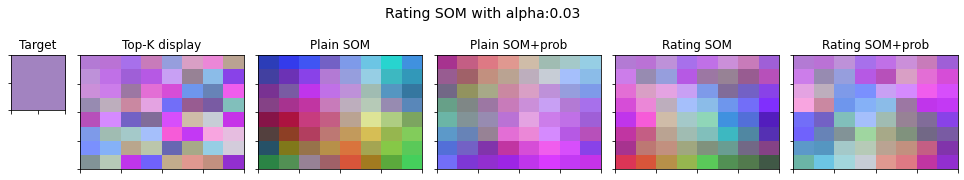

In [14]:
displays = [("topk",True,5,0.001),("normal",False,10,0.001),("normal",True,10,0.001),("rating",False,10,0.03),("rating",True,10,0.03)]

displayForMethods(displays,0,evalProc,"Rating SOM with alpha:0.03")
plt.tight_layout()
plt.savefig("variantsExample1.png", dpi=300)

<ipython-input-13-d82a2c8af380>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, numOfVariantsX+1, figsize=(figWidth,2.5), gridspec_kw={'width_ratios': widthRatios})


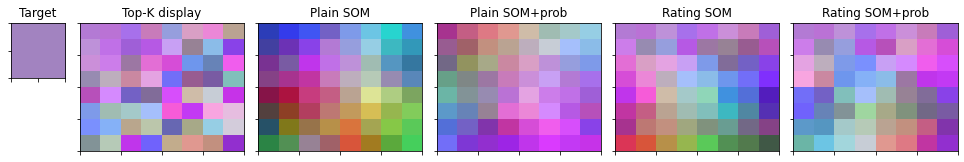

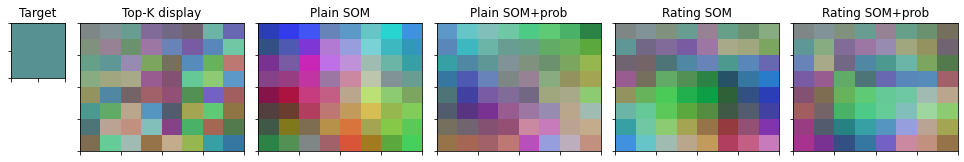

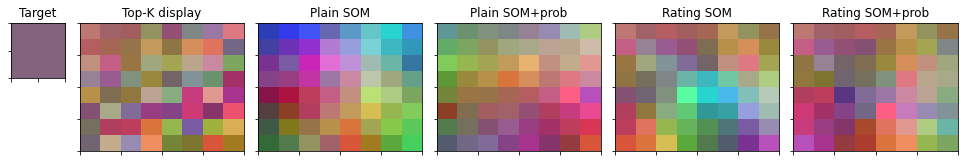

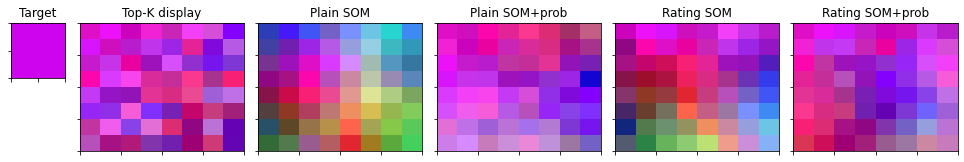

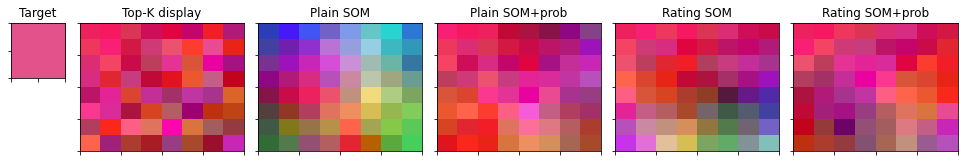

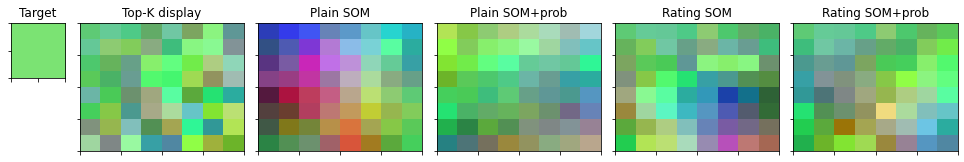

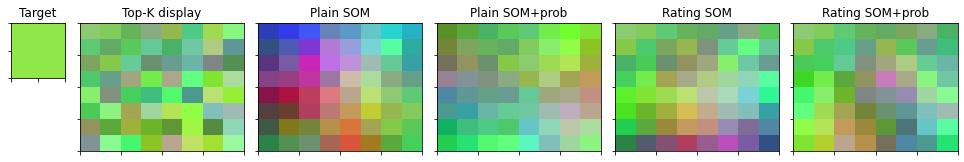

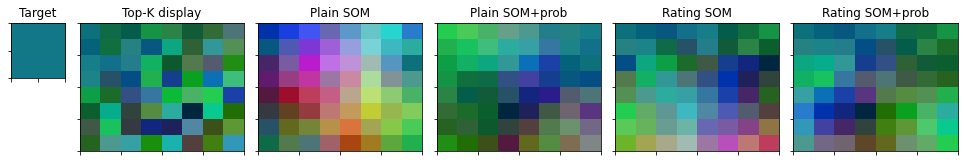

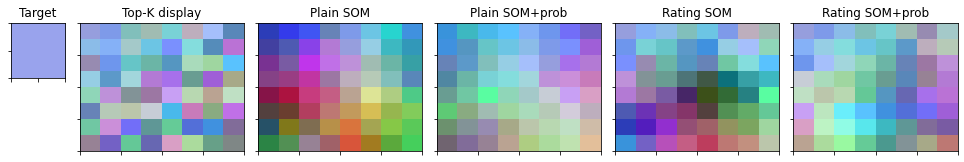

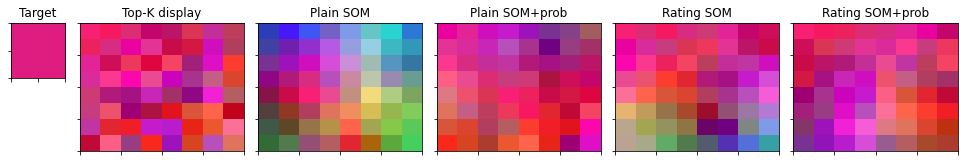

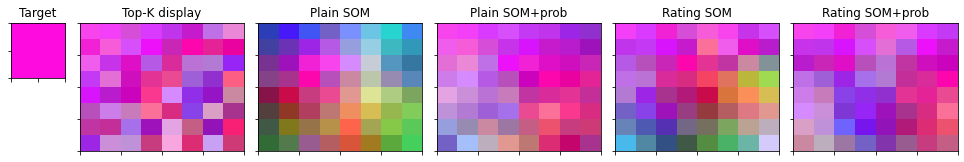

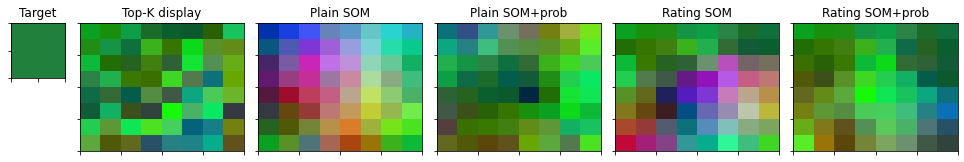

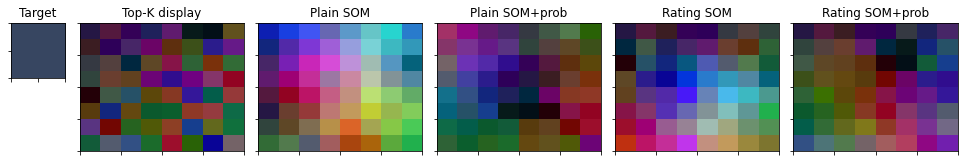

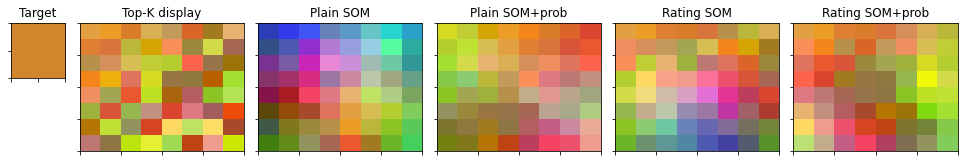

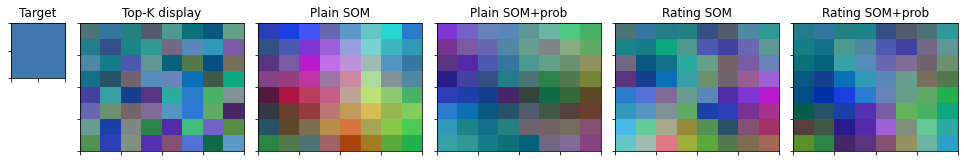

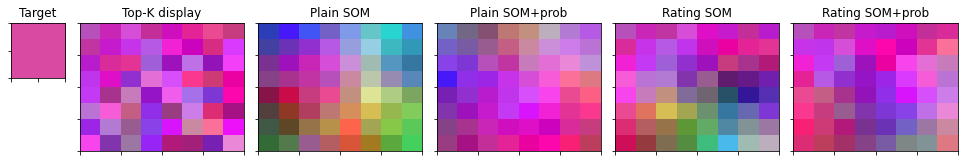

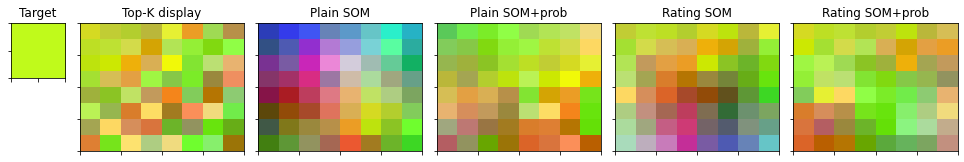

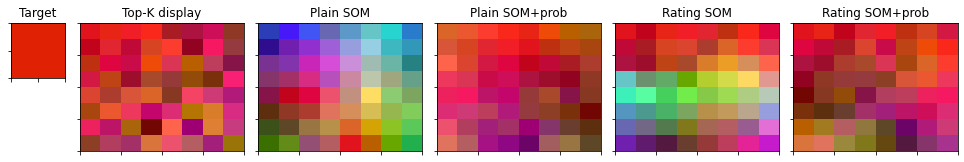

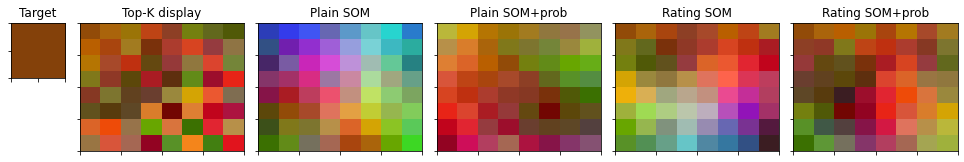

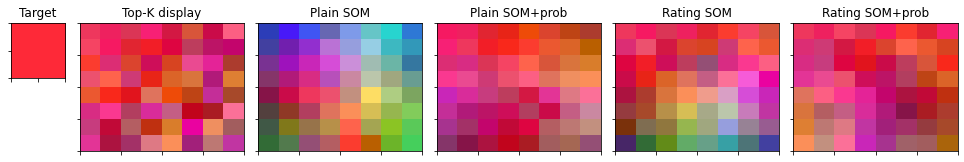

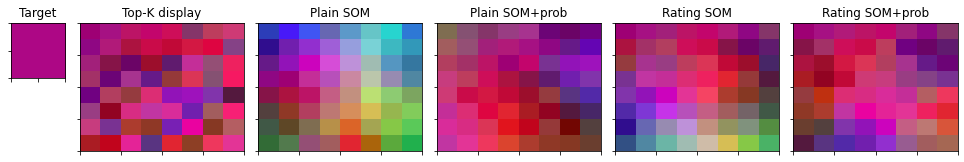

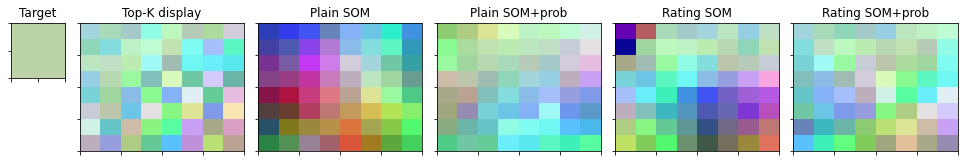

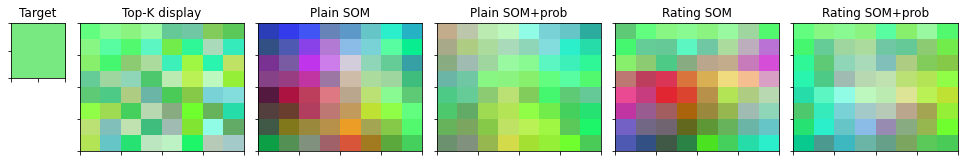

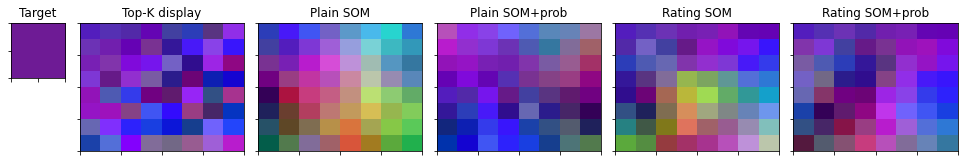

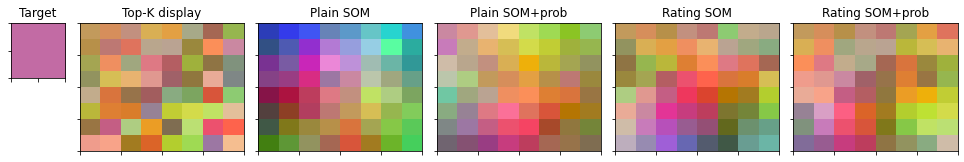

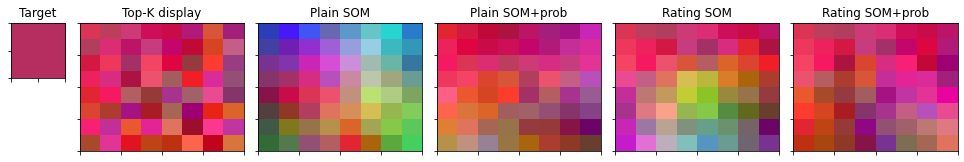

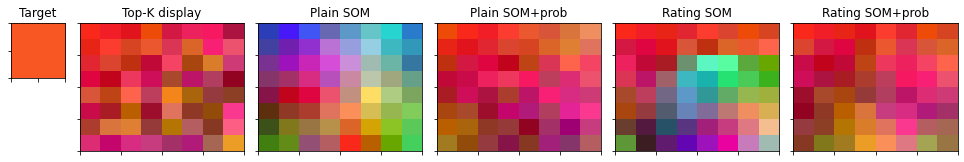

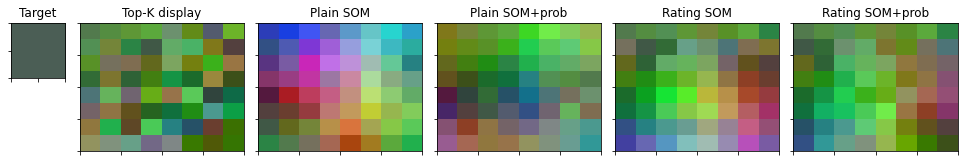

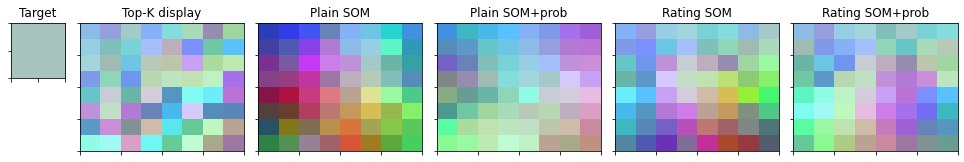

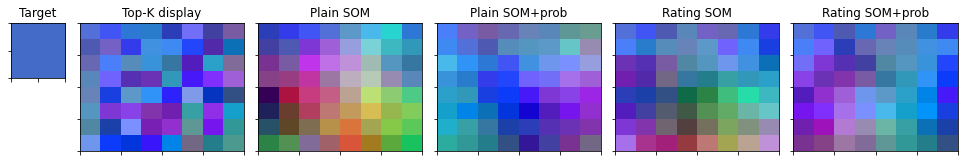

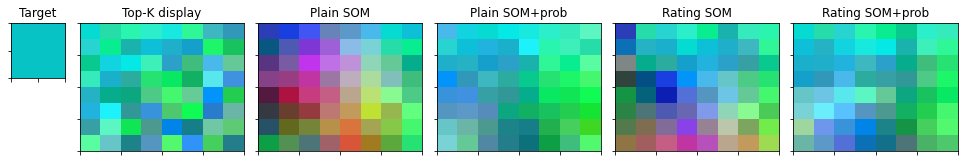

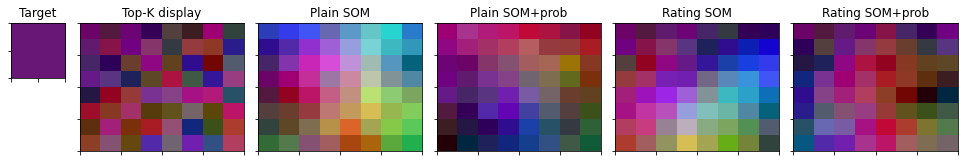

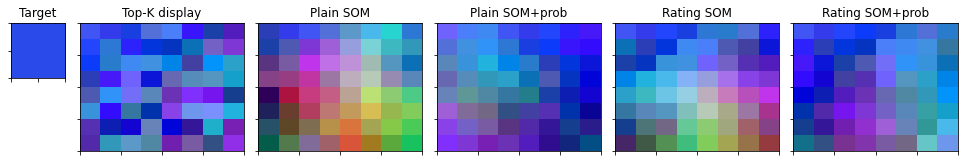

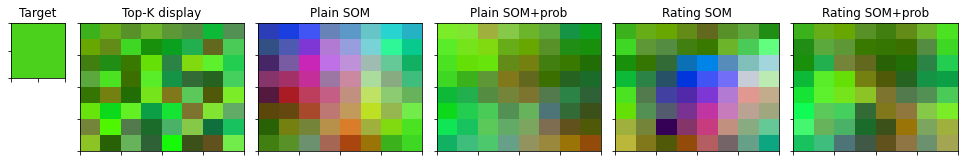

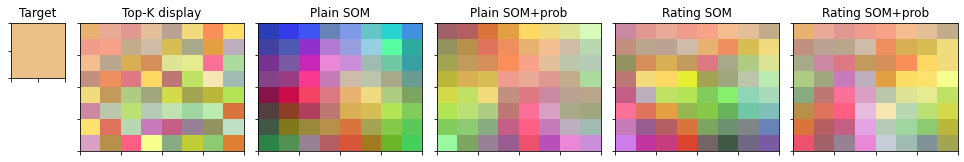

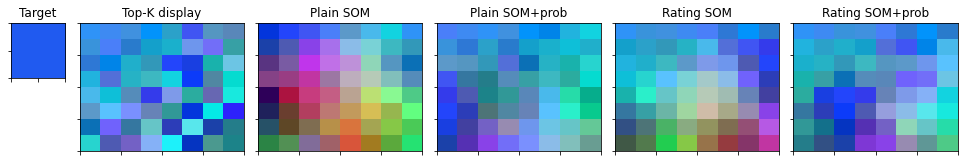

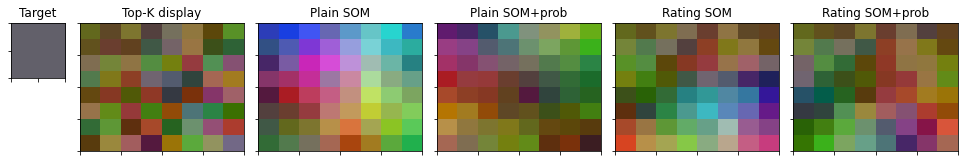

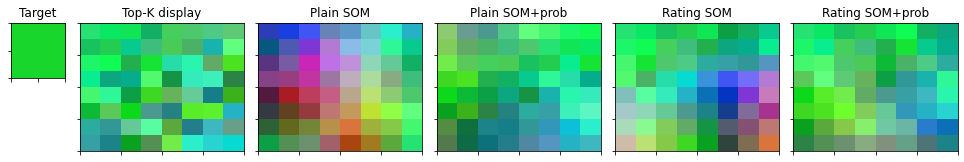

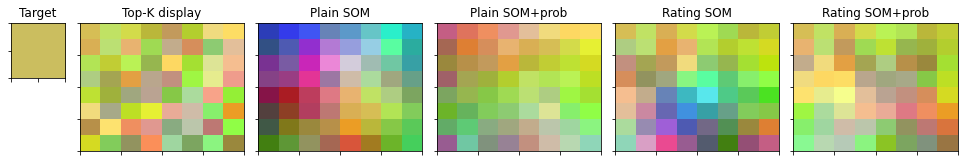

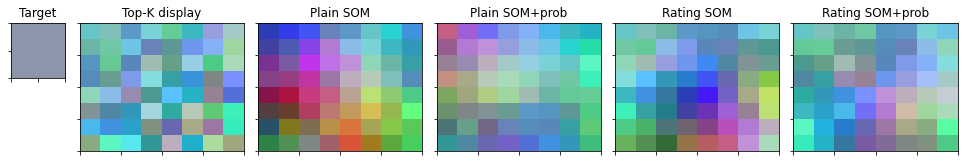

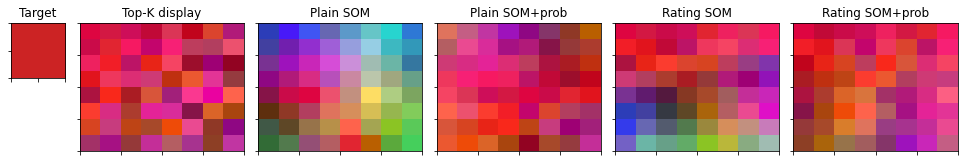

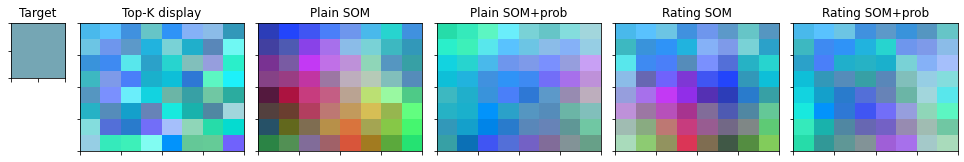

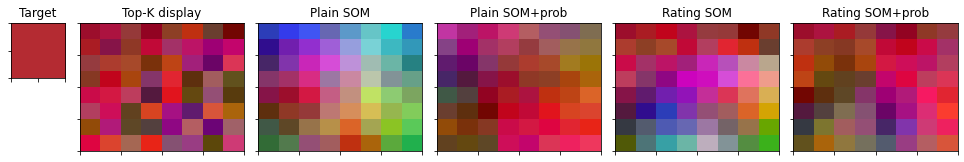

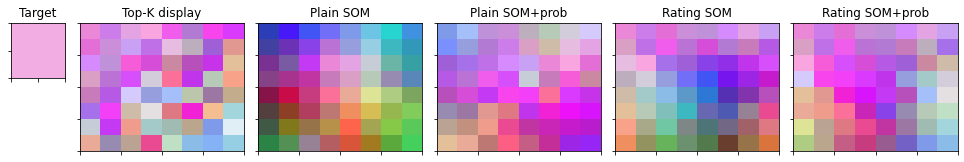

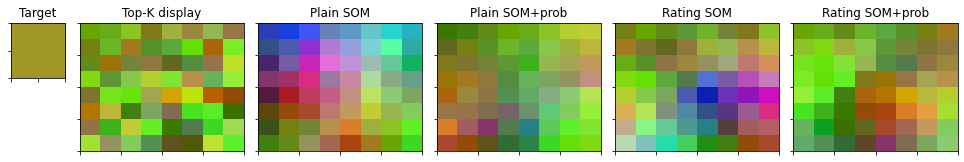

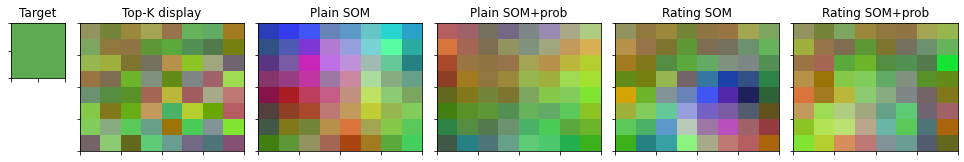

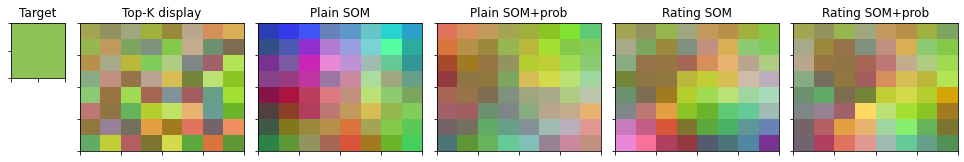

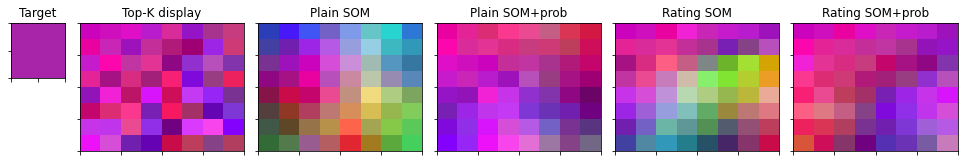

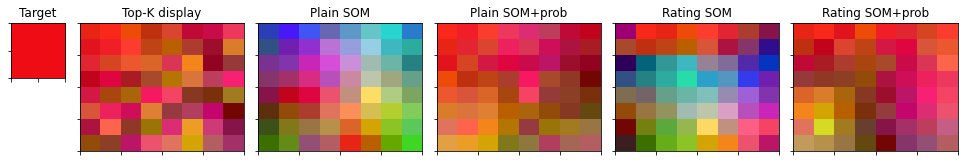

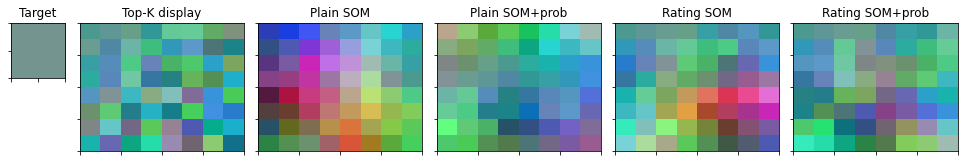

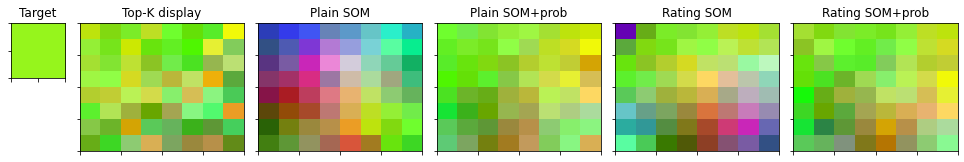

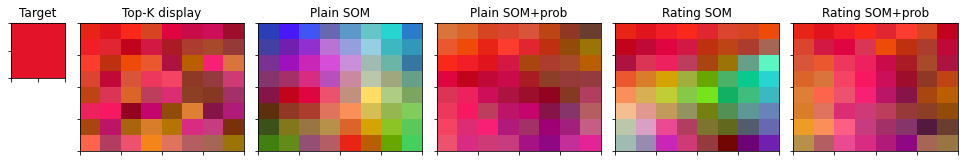

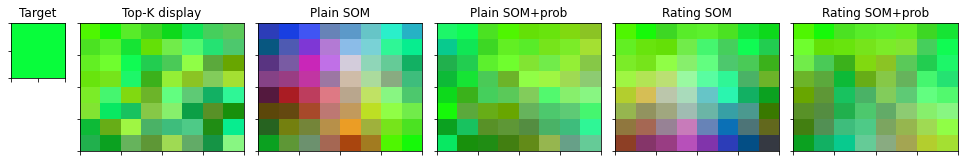

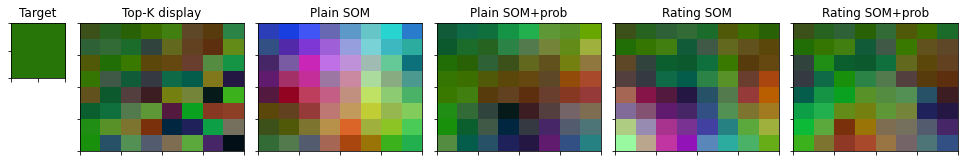

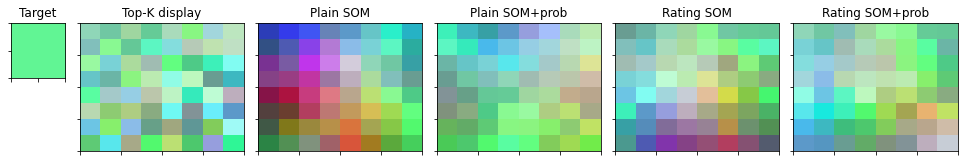

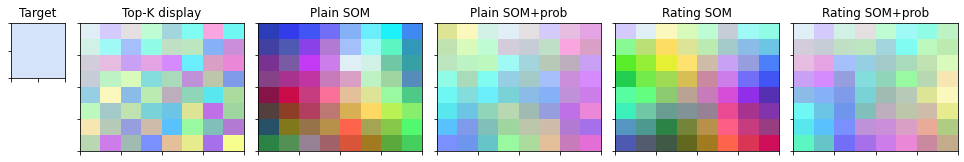

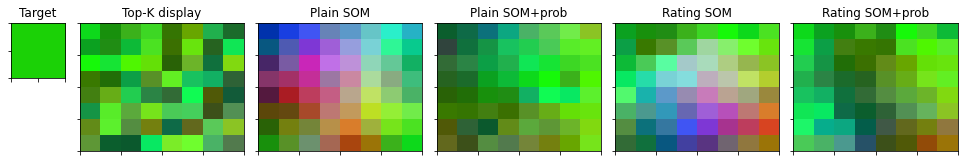

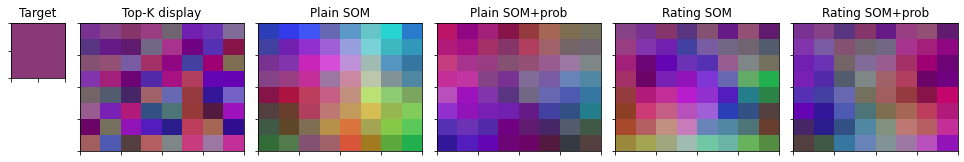

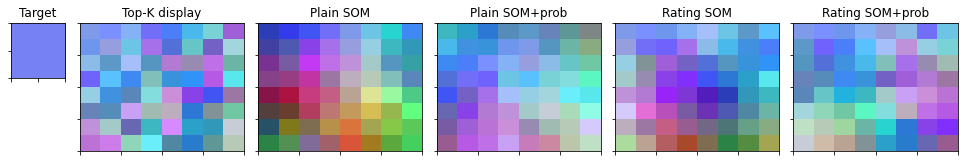

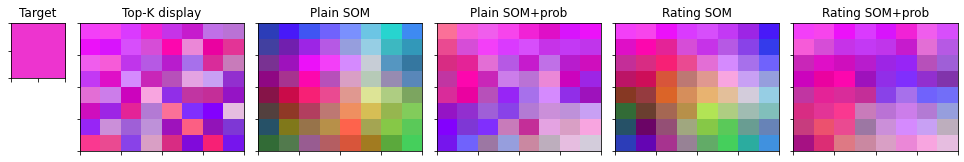

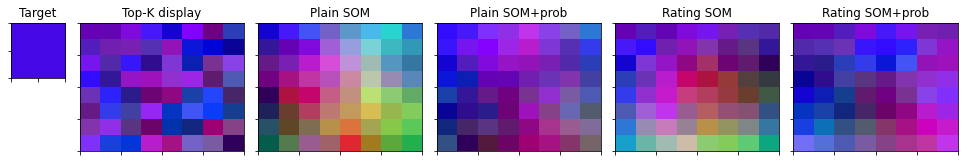

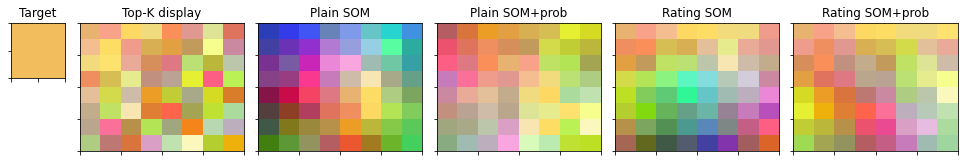

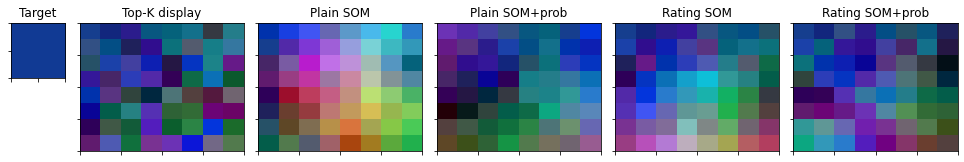

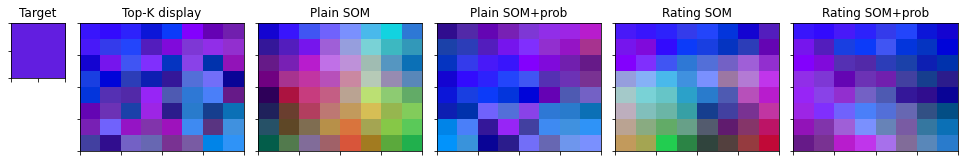

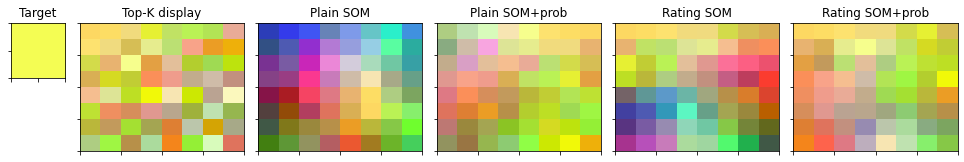

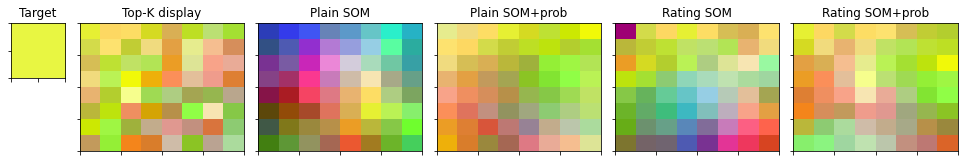

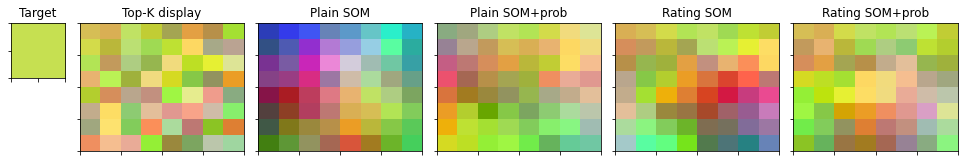

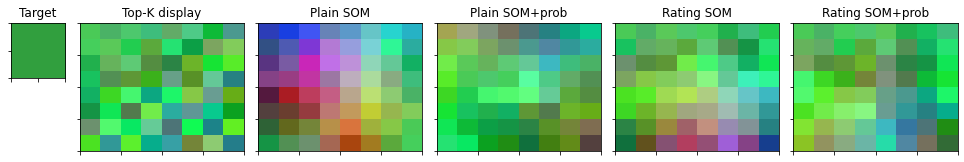

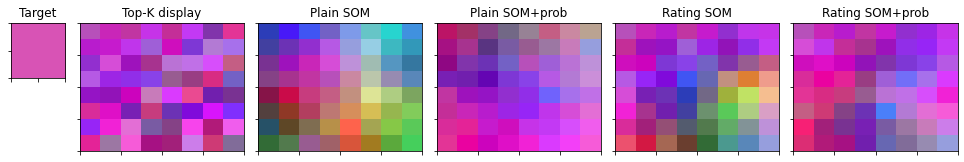

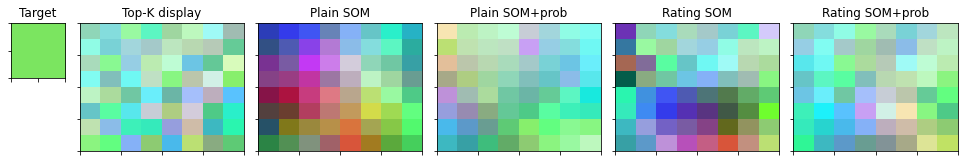

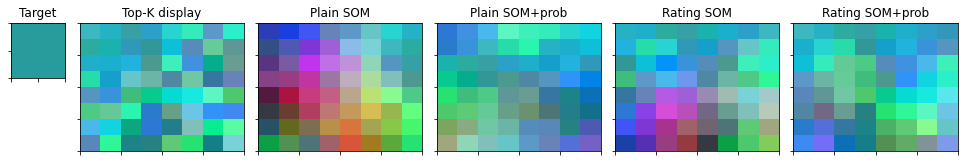

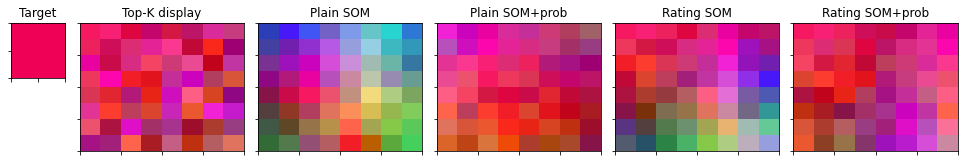

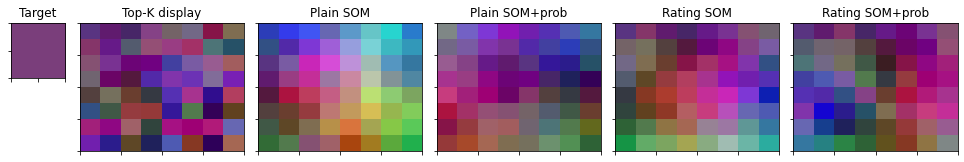

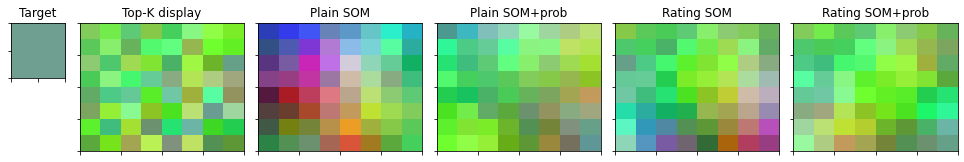

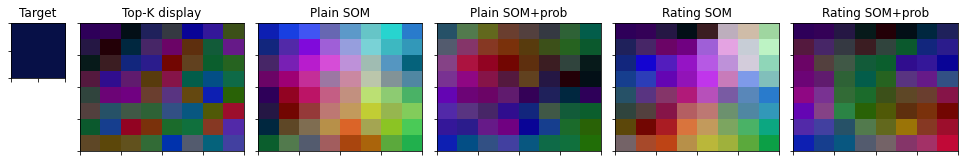

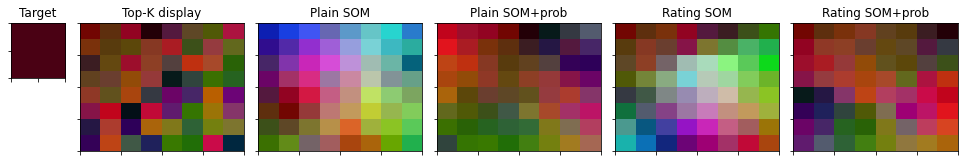

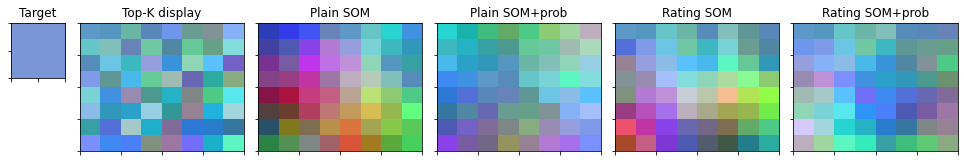

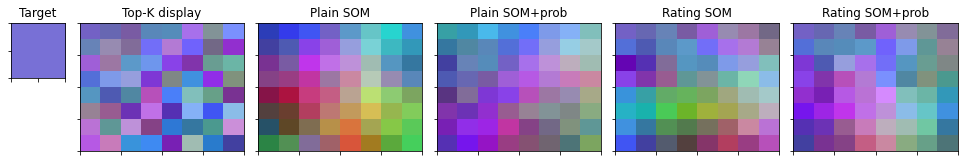

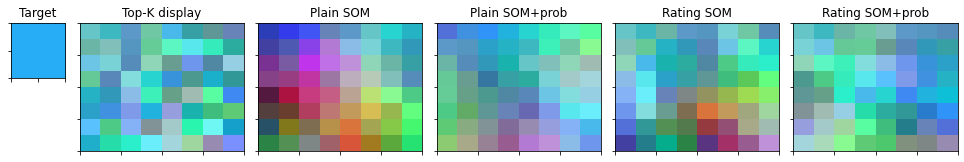

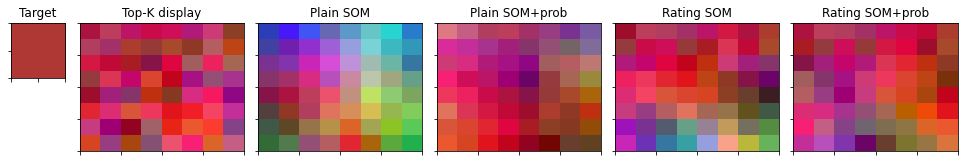

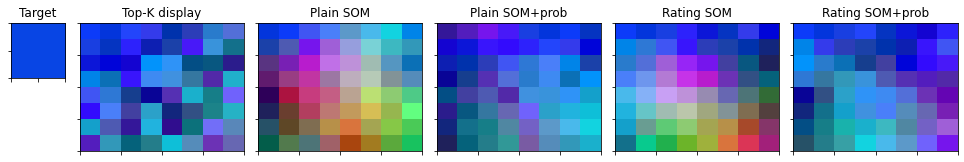

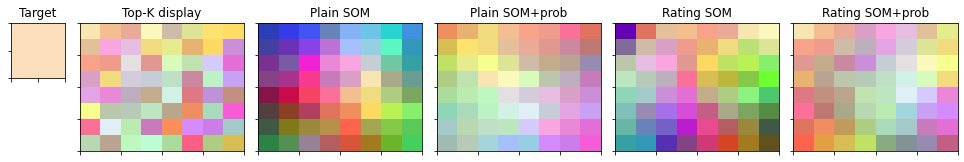

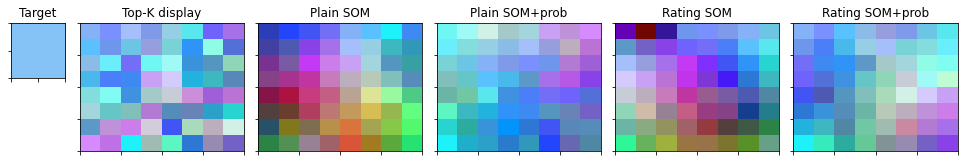

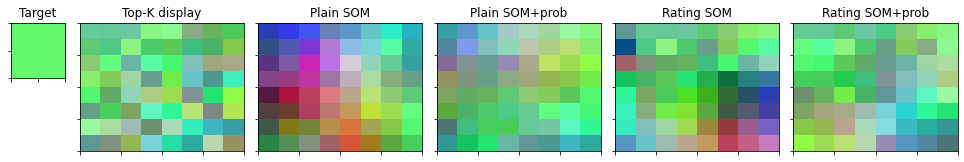

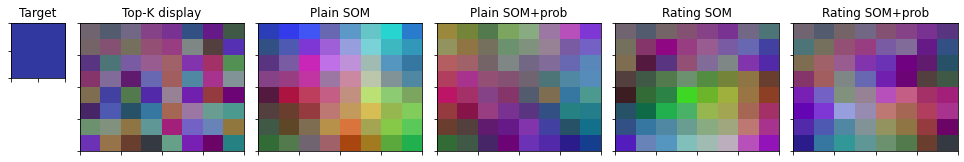

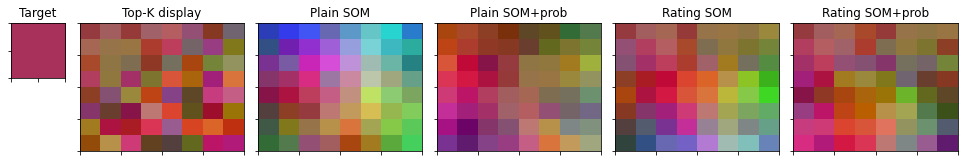

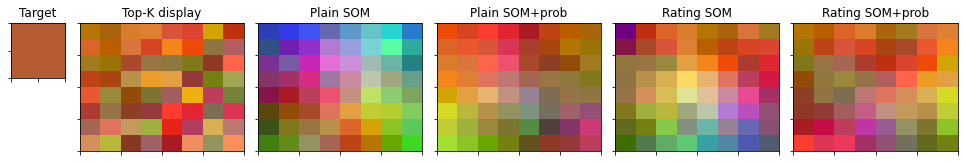

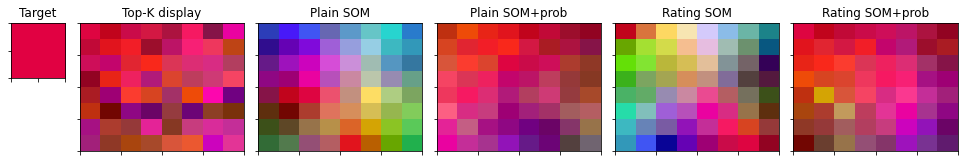

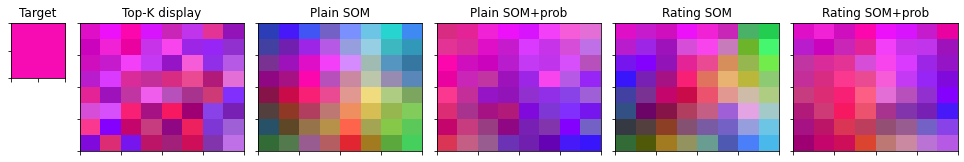

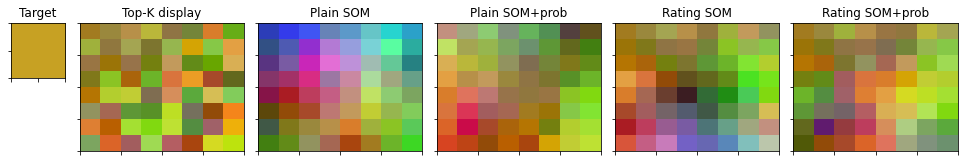

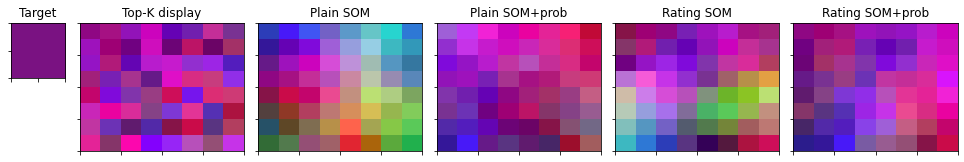

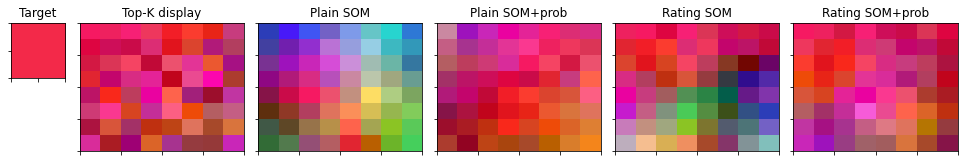

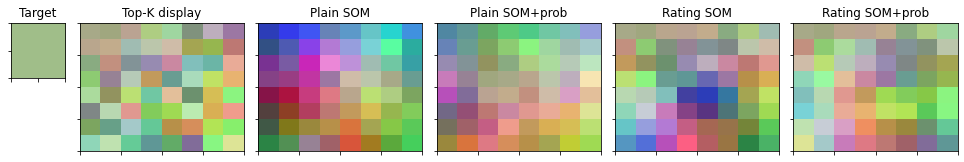

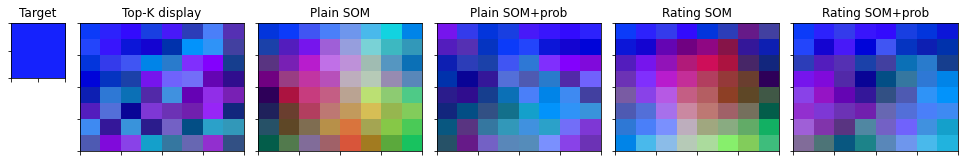

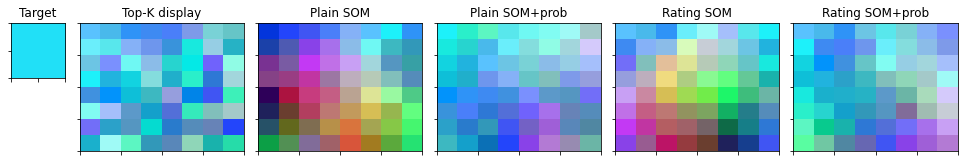

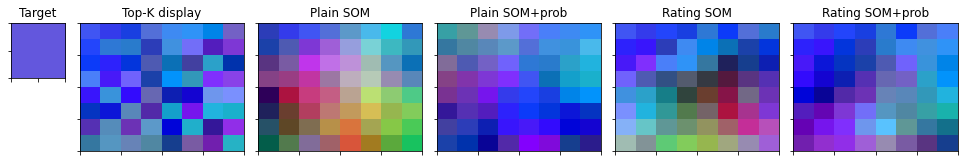

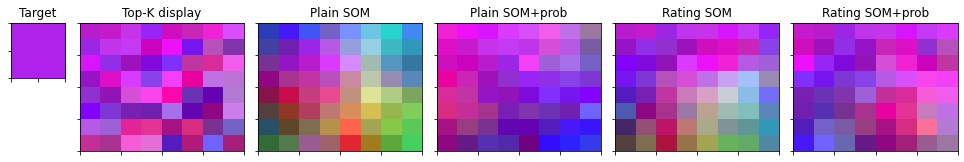

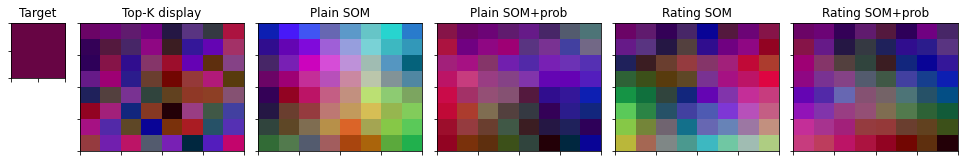

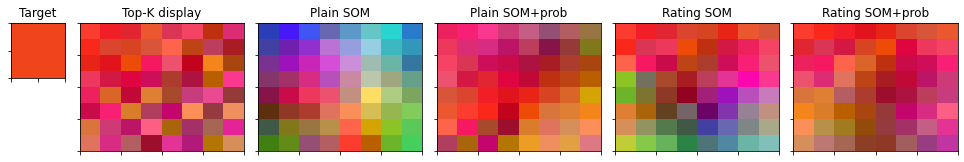

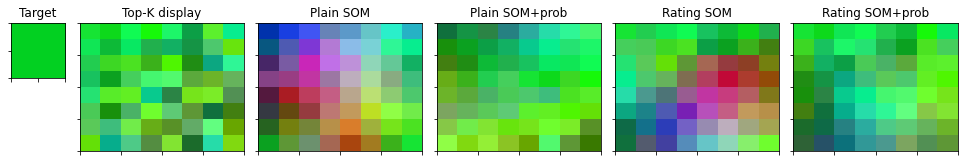

In [15]:
for i in range(0,100):
    displayForMethods(displays,i,evalProc,"")#Rating SOM with alpha:0.1
    plt.tight_layout()
    plt.savefig("img/variants/variantsExample_"+str(i)+".png", dpi=300)
    